## SECTION-1 End to End RAG Pipeline

1.   List item
2.   List item



Tools used:
- Unstructured for document loading
- Open source Embedding model (BAAI/bge-small-en-v1.5) & OpenAI Embeddings
- OpenAI LLM
- Chroma for vector store.
- Langchain for RAG pipeline creation

![RAG Pipeline](https://drive.google.com/uc?export=view&id=1BsTMTn9EErhefS-Cd4xapo92aQC_p7gH)



In [ ]:
%%writefile requirements.txt
langchain_community
langchain
loguru
rich
sentence-transformers==2.3.0
unstructured
unstructured[pdf]
chromadb
rank_bm25
matplotlib
jsonargparse
langchain-openai
pymupdf
streamlit
cohere


Overwriting requirements.txt


In [ ]:
!pip install -r requirements.txt

In [ ]:
# !sudo apt-get update
# !sudo apt-get install tesseract-ocr
# !sudo apt-get install libtesseract-dev


In [ ]:
import os

from langchain.text_splitter import RecursiveCharacterTextSplitter
# from langchain_community.document_loaders import UnstructuredFileLoader
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores import Chroma
from rich import print
# from unstructured.cleaners.core import clean_extra_whitespace, group_broken_paragraphs

In [ ]:
# from rich.pretty import pprint

# def pretty_print(title: str=None, content: Any=None):
#     if title is None:
#         print(content)
#         return
#     print(title)
#     pprint(content)

# from IPython.display import display, HTML

In [ ]:
if not os.path.exists("./data"):
  os.mkdir("./data")

In [ ]:
!wget https://arxiv.org/pdf/2306.02707.pdf -P ./data/
# !wget https://arxiv.org/pdf/1706.03762.pdf -P ./data

--2024-05-22 02:08:16--  https://arxiv.org/pdf/2306.02707.pdf
Resolving arxiv.org (arxiv.org)... 151.101.131.42, 151.101.67.42, 151.101.3.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.131.42|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://arxiv.org/pdf/2306.02707 [following]
--2024-05-22 02:08:16--  http://arxiv.org/pdf/2306.02707
Connecting to arxiv.org (arxiv.org)|151.101.131.42|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1458242 (1.4M) [application/pdf]
Saving to: ‘./data/2306.02707.pdf.1’

2306.02707.pdf.1    100%[===================>]   1.39M  --.-KB/s    in 0.04s   

2024-05-22 02:08:16 (33.0 MB/s) - ‘./data/2306.02707.pdf.1’ saved [1458242/1458242]



In [ ]:
# !apt-get install poppler-utils
# !pip install pytesseract

In [ ]:
# !pip install "unstructured[all-docs]"
# !pip install -q pytesseract
# !pip install -q poppler-utils
# # !pip install -q libmagic-dev

### SECTION 1.1 Load PDF files

In [ ]:
def load_pdf_unstructuredio(files = "2306.02707.pdf"):
    """
    Loads documents from PDF files using UnstructuredFileLoader.

    Parameters:
    - files: A string representing a single file path or a list of strings representing multiple file paths.

    Returns:
    - A list of Document objects loaded from the provided PDF files.

    Raises:
    - FileNotFoundError: If any of the provided file paths do not exist.
    - Exception: For any other issues encountered during file loading.

    The function applies post-processing steps such as cleaning extra whitespace and grouping broken paragraphs.
    """
    if not isinstance(files, list):
        files = [files]  # Ensure 'files' is always a list

    documents = []
    for file_path in files:
        try:
            loader = UnstructuredFileLoader(
                file_path,
                post_processors=[clean_extra_whitespace, group_broken_paragraphs],
            )
            documents.extend(loader.load())
        except FileNotFoundError as e:
            print(f"File not found: {e.filename}")
            raise
        except Exception as e:
            print(f"An error occurred while loading {file_path}: {e}")
            raise

    return documents

In [ ]:
# pip install pymupdf

#### NOTE: I found that UnstructuredIO can be really slow but PyMuPDF seems to work well instead. So Here are functions that replace the same functionaly with PyMuDPF laoder

In [ ]:
import fitz  # PyMuPDF
from langchain.docstore.document import Document

def load_pdf(files="data/2306.02707.pdf"):
    """
    Loads documents from PDF files using PyMuPDF.

    Parameters:
    - files: A string representing a single file path or a list of strings representing multiple file paths.

    Returns:
    - A list of Document objects loaded from the provided PDF files.

    Raises:
    - FileNotFoundError: If any of the provided file paths do not exist.
    - Exception: For any other issues encountered during file loading.

    The function applies post-processing steps such as cleaning extra whitespace and grouping broken paragraphs.
    """
    if not isinstance(files, list):
        files = [files]  # Ensure 'files' is always a list

    documents = []
    for file_path in files:
        try:
            # Open the PDF file
            doc = fitz.open(file_path)
            text = ""
            # Extract text from each page
            for page_num in range(len(doc)):
                page = doc.load_page(page_num)
                text += page.get_text("text")

            # Apply post-processing steps
            text = clean_extra_whitespace(text)
            text = group_broken_paragraphs(text)

            # Create a Document object
            document = Document(
                page_content=text,
                metadata={"source": file_path}
            )
            documents.append(document)
        except FileNotFoundError as e:
            print(f"File not found: {e.filename}")
            raise
        except Exception as e:
            print(f"An error occurred while loading {file_path}: {e}")
            raise

    return documents

def clean_extra_whitespace(text):
    """
    Cleans extra whitespace from the provided text.

    Parameters:
    - text: A string representing the text to be cleaned.

    Returns:
    - A string with extra whitespace removed.
    """
    return ' '.join(text.split())

def group_broken_paragraphs(text):
    """
    Groups broken paragraphs in the provided text.

    Parameters:
    - text: A string representing the text to be processed.

    Returns:
    - A string with broken paragraphs grouped.
    """
    return text.replace("\n", " ").replace("\r", " ")


##### Please Note - Large PDF files take a while to be processed via unstrusturedio.

In [ ]:
data = load_pdf()
# data

In [ ]:
print(data[0].page_content)

Orca: Progressive Learning from Complex Explanation Traces of GPT-4 Subhabrata Mukherjee∗†, Arindam Mitra∗ Ganesh 
Jawahar, Sahaj Agarwal, Hamid Palangi, Ahmed Awadallah Microsoft Research Abstract Recent research has focused on 
enhancing the capability of smaller models through imitation learning, drawing on the outputs generated by large 
foundation models (LFMs). A number of issues impact the quality of these models, ranging from limited imitation 
signals from shallow LFM outputs; small scale homogeneous training data; and most notably a lack of rigorous 
evaluation resulting in overestimating the small model’s capability as they tend to learn to imitate the style, but
not the reasoning process of LFMs. To address these challenges, we develop Orca, a 13-billion parameter model that 
learns to imitate the reasoning process of LFMs. Orca learns from rich signals from GPT-4 including explanation 
traces; step-by-step thought processes; and other complex instructions, guided by teacher assistance from ChatGPT. 
To promote this progressive learning, we tap into large-scale and diverse imitation data with judicious sampling 
and selection. Orca surpasses conventional state-of-the-art instruction-tuned models such as Vicuna-13B by more 
than 100% in complex zero-shot reasoning benchmarks like Big- Bench Hard (BBH) and 42% on AGIEval. Moreover, Orca 
reaches parity with ChatGPT on the BBH benchmark and shows competitive performance (4 pts gap with optimized system
message) in professional and academic examinations like the SAT, LSAT, GRE, and GMAT, both in zero-shot settings 
without CoT; while trailing behind GPT-4. Our research indicates that learning from step-by-step explanations, 
whether these are generated by humans or more advanced AI models, is a promising direction to improve model 
capabilities and skills. ∗Co-primary authors. Author contributions listed at the end of the paper. †Correspondence 
to subhabrata.mukherjee@microsoft.com We are working with our legal team to publicly release a diff of the model 
weights in accordance with LLaMA’s release policy to be published at https://aka.ms/orca-lm. Work in progress. 
arXiv:2306.02707v1  5 Jun 2023 Contents 1 Introduction 4 1.1 Challenges with Existing Methods . . . . . . . . . . .
. . . . . . . . . . . . . 5 1.2 Key Contributions . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
6 2 Preliminaries 7 2.1 Instruction Tuning . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 7 2.2 
Role of System Instructions . . . . . . . . . . . . . . . . . . . . . . . . . . . . 7 3 Explanation Tuning 8 3.1 
Dataset Construction . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 8 3.1.1 System Messages . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . 9 3.1.2 Dataset Description and Sampling from the FLAN-v2 
Collection . . . 9 3.1.3 ChatGPT as Teaching Assistant . . . . . . . . . . . . . . . . . . . . . 12 3.2 Training . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 13 4 Experiment Setup 14 4.1 Baselines 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 14 4.2 Tasks . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . 15 4.2.1 Open-ended Generation Capabilities . . . . . . . .
. . . . . . . . . . . 15 4.2.2 Reasoning Capabilities . . . . . . . . . . . . . . . . . . . . . . . . . . . 16 5 
Evaluation for Open-ended Generation 17 6 Evaluation for Reasoning 17 6.1 AGIEval Results . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . 17 6.2 Big-Bench Hard Results . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . 20 7 Evaluation for Safety 23 7.1 Truthful Question Answering . . . . . . . . . . . . . . . . . . .
. . . . . . . . 23 7.2 Toxic Content Generation . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 26 7.3 
Note on Hallucination and Tool Augmented LFMs . . . . . . . . . . . . . . . 27 8 Limitations 28 9 Conclusi

In [ ]:
directory = "./data"
# Get all files in the directory
files = os.listdir(directory)
# Filter out only PDF files
pdf_files = [f"{directory}/{file}" for file in files if file.endswith('.pdf')]
print(pdf_files)


['./data/2306.02707.pdf']

In [ ]:
documents = load_pdf(files=pdf_files)

In [ ]:
len(documents)

1

In [ ]:
print(documents[0].page_content)

Orca: Progressive Learning from Complex Explanation Traces of GPT-4 Subhabrata Mukherjee∗†, Arindam Mitra∗ Ganesh 
Jawahar, Sahaj Agarwal, Hamid Palangi, Ahmed Awadallah Microsoft Research Abstract Recent research has focused on 
enhancing the capability of smaller models through imitation learning, drawing on the outputs generated by large 
foundation models (LFMs). A number of issues impact the quality of these models, ranging from limited imitation 
signals from shallow LFM outputs; small scale homogeneous training data; and most notably a lack of rigorous 
evaluation resulting in overestimating the small model’s capability as they tend to learn to imitate the style, but
not the reasoning process of LFMs. To address these challenges, we develop Orca, a 13-billion parameter model that 
learns to imitate the reasoning process of LFMs. Orca learns from rich signals from GPT-4 including explanation 
traces; step-by-step thought processes; and other complex instructions, guided by teacher assistance from ChatGPT. 
To promote this progressive learning, we tap into large-scale and diverse imitation data with judicious sampling 
and selection. Orca surpasses conventional state-of-the-art instruction-tuned models such as Vicuna-13B by more 
than 100% in complex zero-shot reasoning benchmarks like Big- Bench Hard (BBH) and 42% on AGIEval. Moreover, Orca 
reaches parity with ChatGPT on the BBH benchmark and shows competitive performance (4 pts gap with optimized system
message) in professional and academic examinations like the SAT, LSAT, GRE, and GMAT, both in zero-shot settings 
without CoT; while trailing behind GPT-4. Our research indicates that learning from step-by-step explanations, 
whether these are generated by humans or more advanced AI models, is a promising direction to improve model 
capabilities and skills. ∗Co-primary authors. Author contributions listed at the end of the paper. †Correspondence 
to subhabrata.mukherjee@microsoft.com We are working with our legal team to publicly release a diff of the model 
weights in accordance with LLaMA’s release policy to be published at https://aka.ms/orca-lm. Work in progress. 
arXiv:2306.02707v1  5 Jun 2023 Contents 1 Introduction 4 1.1 Challenges with Existing Methods . . . . . . . . . . .
. . . . . . . . . . . . . 5 1.2 Key Contributions . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
6 2 Preliminaries 7 2.1 Instruction Tuning . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 7 2.2 
Role of System Instructions . . . . . . . . . . . . . . . . . . . . . . . . . . . . 7 3 Explanation Tuning 8 3.1 
Dataset Construction . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 8 3.1.1 System Messages . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . 9 3.1.2 Dataset Description and Sampling from the FLAN-v2 
Collection . . . 9 3.1.3 ChatGPT as Teaching Assistant . . . . . . . . . . . . . . . . . . . . . 12 3.2 Training . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 13 4 Experiment Setup 14 4.1 Baselines 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 14 4.2 Tasks . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . 15 4.2.1 Open-ended Generation Capabilities . . . . . . . .
. . . . . . . . . . . 15 4.2.2 Reasoning Capabilities . . . . . . . . . . . . . . . . . . . . . . . . . . . 16 5 
Evaluation for Open-ended Generation 17 6 Evaluation for Reasoning 17 6.1 AGIEval Results . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . 17 6.2 Big-Bench Hard Results . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . 20 7 Evaluation for Safety 23 7.1 Truthful Question Answering . . . . . . . . . . . . . . . . . . .
. . . . . . . . 23 7.2 Toxic Content Generation . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 26 7.3 
Note on Hallucination and Tool Augmented LFMs . . . . . . . . . . . . . . . 27 8 Limitations 28 9 Conclusi

### SECTION 1.2 Splitting Documents into Chunks

---



#### Introduction
Here, we divide the documents from our knowledge base into smaller sections/chunks, which will act as the basis for the reader LLM's responses.

The objective is to create a collection of semantically relevant snippets. The size of these snippets is crucial: too small, and they may cut off ideas; too large, and they could dilute the concepts.

### Recursive Chunking Method

#### Overview
The Recursive Chunking Method systematically divides text into increasingly smaller sections by applying a hierarchy of separators. This approach ensures a step-by-step breakdown, preserving the text's overall structure while accommodating size variations in the resulting chunks.

#### How It Works
Given a list of separators arranged by their significance (e.g., `["\n\n", "\n", ".", ""]`), the process unfolds as follows:

1. **Initial Split**: Begin by dividing the document at every occurrence of the most significant separator (`"\n\n"`).
2. **Further Splits**: Subsequent divisions are made using the next separator in the list (`"\n"`), followed by sentence terminators (`"."`).
3. **Size Adjustment**: If chunks still exceed the maximum allowable size, they are further split, ensuring they fit the size criteria.

#### Outcome
This method maintains the document's overarching structure, even though chunk sizes may vary slightly due to the recursive splitting process.


In [ ]:
# https://chunkviz.up.railway.app/

In [ ]:
# split_documents_into_chunks()

from langchain.text_splitter import RecursiveCharacterTextSplitter


text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2500,  # the maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # the number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
)

docs_processed = []
for doc in documents:
    docs_processed += text_splitter.split_documents([doc])

In [ ]:
docs_processed

[Document(page_content='Orca: Progressive Learning from Complex Explanation Traces of GPT-4 Subhabrata Mukherjee∗†, Arindam Mitra∗ Ganesh Jawahar, Sahaj Agarwal, Hamid Palangi, Ahmed Awadallah Microsoft Research Abstract Recent research has focused on enhancing the capability of smaller models through imitation learning, drawing on the outputs generated by large foundation models (LFMs). A number of issues impact the quality of these models, ranging from limited imitation signals from shallow LFM outputs; small scale homogeneous training data; and most notably a lack of rigorous evaluation resulting in overestimating the small model’s capability as they tend to learn to imitate the style, but not the reasoning process of LFMs. To address these challenges, we develop Orca, a 13-billion parameter model that learns to imitate the reasoning process of LFMs. Orca learns from rich signals from GPT-4 including explanation traces; step-by-step thought processes; and other complex instructions,

In [ ]:
print(f"Number of chunks: {len(docs_processed)}")

Number of chunks: 60

In [ ]:
print(docs_processed[0].page_content)

Orca: Progressive Learning from Complex Explanation Traces of GPT-4 Subhabrata Mukherjee∗†, Arindam Mitra∗ Ganesh 
Jawahar, Sahaj Agarwal, Hamid Palangi, Ahmed Awadallah Microsoft Research Abstract Recent research has focused on 
enhancing the capability of smaller models through imitation learning, drawing on the outputs generated by large 
foundation models (LFMs). A number of issues impact the quality of these models, ranging from limited imitation 
signals from shallow LFM outputs; small scale homogeneous training data; and most notably a lack of rigorous 
evaluation resulting in overestimating the small model’s capability as they tend to learn to imitate the style, but
not the reasoning process of LFMs. To address these challenges, we develop Orca, a 13-billion parameter model that 
learns to imitate the reasoning process of LFMs. Orca learns from rich signals from GPT-4 including explanation 
traces; step-by-step thought processes; and other complex instructions, guided by teacher assistance from ChatGPT. 
To promote this progressive learning, we tap into large-scale and diverse imitation data with judicious sampling 
and selection. Orca surpasses conventional state-of-the-art instruction-tuned models such as Vicuna-13B by more 
than 100% in complex zero-shot reasoning benchmarks like Big- Bench Hard (BBH) and 42% on AGIEval. Moreover, Orca 
reaches parity with ChatGPT on the BBH benchmark and shows competitive performance (4 pts gap with optimized system
message) in professional and academic examinations like the SAT, LSAT, GRE, and GMAT, both in zero-shot settings 
without CoT; while trailing behind GPT-4. Our research indicates that learning from step-by-step explanations, 
whether these are generated by humans or more advanced AI models, is a promising direction to improve model 
capabilities and skills. ∗Co-primary authors. Author contributions listed at the end of the paper. †Correspondence 
to subhabrata.mukherjee@microsoft.com We are working with our legal team to publicly release a diff of the model 
weights in accordance with LLaMA’s release policy to be published at https://aka.ms/orca-lm. Work in progress. 
arXiv:2306.02707v1  5 Jun 2023 Contents 1 Introduction 4 1.1 Challenges with Existing Methods . . . . . . . . . . .
. . . . . . . . . . . . . 5 1.2 Key Contributions . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
6 2 Preliminaries 7 2.1 Instruction Tuning . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 7 2.2

In [ ]:
print(docs_processed[50].page_content)

You now have 6 liters of water remaining in the 12 liter jug. Pour the water from the 6 liter jug out. Pour the 6 
liters of water from the 12 liter jug into the empty 6 liter jug. Now you have 6 liters of water in the 6 liter 
jug. ### GPT-4: To measure exactly 6 liters using a 12-liter jug and a 6-liter jug, follow these steps: Fill the 
6-liter jug completely. Pour the water from the 6-liter jug into the 12-liter jug. 43 Fill the 6-liter jug again. 
Carefully pour the water from the 6-liter jug into the 12-liter jug until the 12-liter jug is full. Since the 
12-liter jug can hold exactly 12 liters, there will be 6 liters of water left in the 6-liter jug. Now you have 
exactly 6 liters of water in the 6-liter jug. Figure 30: Case Study 11: Commonsense Question Answering from Yejin 
Choi’s talk “Why AI Is Incredibly Smart and Shockingly Stupid | Yejin Choi | 
TED”https://www.youtube.com/watch?v=SvBR0OGT5VI 11.11 Hallucination ### System:: ### Human:: Generate a CV for 
Prof. Yejin Choi of the University of Washington in the following format: Name:, Address:, Phone:, Email:, 
Professional Summary: ### GPT-4: Name: Prof. Yejin Choi Address: Paul G. Allen School of Computer Science & 
Engineering, University of Washington, Seattle, WA Phone: [Phone number] Email: yejin@cs.washington.edu 
Professional Summary: Prof. Yejin Choi is a respected faculty member at the Paul G. Allen School of Computer 
Science & Engineering at the University of Washington, where she has been teaching and conducting research since 
2014. With a strong background in natural language processing, artificial intelligence, and machine learning, she 
has established herself as a leader in the field of computer science. Prof. Choi has made significant contributions
to the development of innovative algorithms and models for language understanding, as well as the ethical 
considerations surrounding AI technology. Her dedication to her research and teaching has been recognized with 
numerous awards and honors throughout her career. ### ChatGPT: Name: Prof. Yejin Choi Address: Department of 
Psychology, University of Washington, Box 351525, Seattle, WA 98195-1525 Phone: (123) 456-7890 Email: ychoi@uw.edu 
Professional Summary: Highly accomplished and respected professor with extensive experience in research, teaching, 
and mentoring. Recognized for expertise in cognitive neuroscience, memory, and emotion regulation. Skilled in grant
writing and project management. Seeking opportunities to collaborate on research

### SECTION 1.3 Experimenting with Chunk Sizes using RecursiveCharacterTextSplitter

#### Introduction
We are exploring the effects of various chunk sizes on text segmentation using the RecursiveCharacterTextSplitter from Langchain. This experiment is designed to refine our methods for optimally dividing text.

#### Parameters Explained
- **Chunk Size**: This parameter sets the length of each text chunk, typically measured in characters. We begin with a predetermined chunk size to monitor how the text is segmented.
- **Chunk Overlap**: This allows for a slight overlap between consecutive chunks to prevent ideas from being split across two chunks. Initially, the overlap is set to 10% of the chunk size, but adjustments may lead to different results.

#### Purpose
The objective of this experiment is to investigate how varying chunk size and overlap affect text division. By testing different configurations, we seek to discover a strategy that maintains the coherence of ideas while effectively segmenting the text.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer

EMBEDDING_MODEL_NAME = 'BAAI/bge-small-en-v1.5'

def plot_docs_tokens(docs_processed, EMBEDDING_MODEL_NAME):

    print(f"Model's maximum sequence length: {SentenceTransformer(EMBEDDING_MODEL_NAME).max_seq_length}")

    tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
    lengths = [len(tokenizer.encode(doc.page_content)) for doc in docs_processed]
    fig = pd.Series(lengths).hist()
    plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
    plt.show()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's maximum sequence length: 512

Token indices sequence length is longer than the specified maximum sequence length for this model (620 > 512). Running this sequence through the model will result in indexing errors


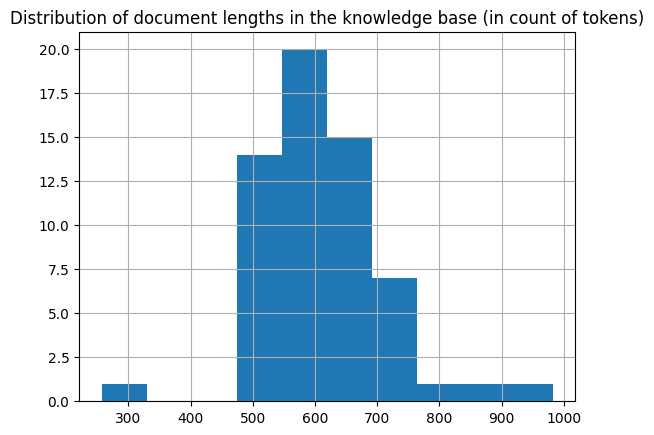

In [ ]:
plot_docs_tokens(docs_processed, EMBEDDING_MODEL_NAME)

In [ ]:

def split_documents(
    chunk_size: int,
    knowledge_base,
    tokenizer_name= EMBEDDING_MODEL_NAME,
):
    """
    Splits documents into chunks of maximum size `chunk_size` tokens, using a specified tokenizer.

    Parameters:
    - chunk_size: The maximum number of tokens for each chunk.
    - knowledge_base: A list of LangchainDocument objects to be split.
    - tokenizer_name: (Optional) The name of the tokenizer to use. Defaults to `EMBEDDING_MODEL_NAME`.

    Returns:
    - A list of LangchainDocument objects, each representing a chunk. Duplicates are removed based on `page_content`.

    Raises:
    - ImportError: If necessary modules for tokenization are not available.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
    )

    docs_processed = (text_splitter.split_documents([doc]) for doc in knowledge_base)
    # Flatten list and remove duplicates more efficiently
    unique_texts = set()
    docs_processed_unique = []
    for doc_chunk in docs_processed:
        for doc in doc_chunk:
            if doc.page_content not in unique_texts:
                unique_texts.add(doc.page_content)
                docs_processed_unique.append(doc)

    return docs_processed_unique

In [ ]:
docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    documents,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

In [ ]:
print(f"Number of chunks: {len(docs_processed)}")

Number of chunks: 283

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Model's maximum sequence length: 512

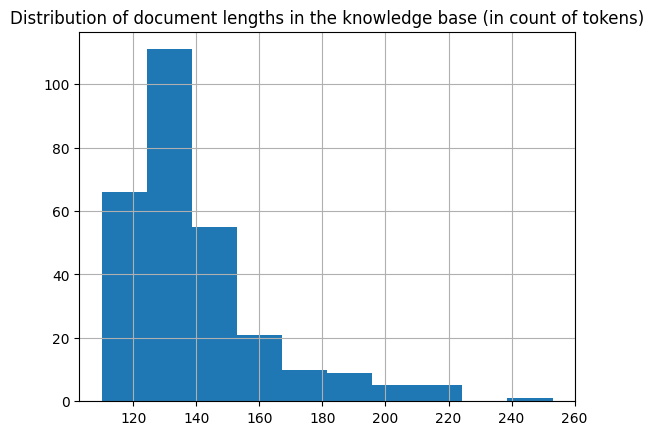

In [ ]:
plot_docs_tokens(docs_processed, EMBEDDING_MODEL_NAME='BAAI/bge-large-en-v1.5')

In [ ]:
print(docs_processed[0].page_content)

Orca: Progressive Learning from Complex Explanation Traces of GPT-4 Subhabrata Mukherjee∗†, Arindam Mitra∗ Ganesh 
Jawahar, Sahaj Agarwal, Hamid Palangi, Ahmed Awadallah Microsoft Research Abstract Recent research has focused on 
enhancing the capability of smaller models through imitation learning, drawing on the outputs generated by large 
foundation models (LFMs). A number of issues impact the quality of these models, ranging from limited imitation 
signals from shallow LFM outputs; small scale homogeneous training data; and most notably a lack of rigorous 
evaluation resulting in overestimating the small model’s capability as they tend to learn to imitate

In [ ]:
# print(docs_processed[50].page_content)

#### SECTION 1.4 The Embedding Model

In [ ]:
from transformers import AutoModel, AutoTokenizer  # Assuming usage of transformers library
from langchain_openai import OpenAIEmbeddings

from typing import Any
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('openai')




def load_embedding_model(
    model_name = "openai", # "BAAI/bge-large-en-v1.5",
    device = "cuda"
) -> HuggingFaceBgeEmbeddings:
    """
    Loads an embedding model from the Hugging Face repository with specified configurations.

    Parameters:
    - model_name: The name of the model to load. Defaults to "BAAI/bge-large-en-v1.5".
    - device: The device to run the model on (e.g., 'cpu', 'cuda', 'mps'). Defaults to 'mps'.

    Returns:
    - An instance of HuggingFaceBgeEmbeddings configured with the specified model and device.

    Raises:
    - ValueError: If an unsupported device is specified.
    - OSError: If the model cannot be loaded from the Hugging Face repository.
    """
    model_kwargs = {"device": device}
    encode_kwargs = {"normalize_embeddings": True}  # For cosine similarity computation

    try:
        if model_name=="openai":
             embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
        else:
            embedding_model = HuggingFaceBgeEmbeddings(
                model_name=model_name,
                model_kwargs=model_kwargs,
                encode_kwargs=encode_kwargs,
            )
        return embedding_model
    except Exception as e:
        print(f"An error occurred while loading the model: {e}")
        raise


In [ ]:
embedding_model = load_embedding_model(model_name="openai")

In [ ]:
embedding_model

OpenAIEmbeddings(client=<openai.resources.embeddings.Embeddings object at 0x7d96fdf77a30>, async_client=<openai.resources.embeddings.AsyncEmbeddings object at 0x7d9630d8dae0>, model='text-embedding-3-small', dimensions=None, deployment='text-embedding-ada-002', openai_api_version='', openai_api_base=None, openai_api_type='', openai_proxy='', embedding_ctx_length=8191, openai_api_key=SecretStr('**********'), openai_organization=None, allowed_special=None, disallowed_special=None, chunk_size=1000, max_retries=2, request_timeout=None, headers=None, tiktoken_enabled=True, tiktoken_model_name=None, show_progress_bar=False, model_kwargs={}, skip_empty=False, default_headers=None, default_query=None, retry_min_seconds=4, retry_max_seconds=20, http_client=None, http_async_client=None, check_embedding_ctx_length=True)

### Vector Store

In [ ]:
from langchain.vectorstores import Chroma

def get_retriever(docs, embedding_model, top_k=3) -> Any:
    """
    Initializes a retriever object to fetch the top_k most relevant documents based on cosine similarity.

    Parameters:
    - docs: A list of documents to be indexed and retrieved.
    - embedding_model: The embedding model to use for generating document embeddings.
    - top_k: The number of top relevant documents to retrieve. Defaults to 3.

    Returns:
    - A retriever object configured to retrieve the top_k relevant documents.

    Raises:
    - ValueError: If any input parameter is invalid.
    """
    # Example of parameter validation (optional)
    if top_k < 1:
        raise ValueError("top_k must be at least 1")

    try:
        vector_store = Chroma.from_documents(
            docs, embedding_model,
        )

        retriever = vector_store.as_retriever(k=top_k)
        # retriever.k = top_k

        return retriever
    except Exception as e:
        print(f"An error occurred while initializing the retriever: {e}")
        raise


In [ ]:
retriever = get_retriever(docs_processed, embedding_model, top_k=3)

In [ ]:
similar_chunks = retriever.get_relevant_documents(query="What is instruction tuning?")
similar_chunks

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


[Document(page_content='Role of System Instructions . . . . . . . . . . . . . . . . . . . . . . . . . . . . 7 3 Explanation Tuning 8 3.1 Dataset Construction . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 8 3.1.1 System Messages . . . . . . . . . . . . . . . . . . . . . . . . .', metadata={'source': './data/2306.02707.pdf', 'start_index': 2500}),
 Document(page_content='4: Instruction-tuning with GPT-49. Given user instructions for a task and an input, the system generates a response. Existing works like Alpaca [7], Vicuna [9] and variants follow a similar template to train small models with ⟨{user instruction, input}, output ⟩. 2 Preliminaries 2.1 Instruction Tuning Instruction tuning [22] is a technique that allows pre-trained language models to learn from input (natural language descriptions of the task) and response pairs, for example, {"instruction": "Arrange the words in the given sentence to form a grammatically correct sentence.", "input": "the quickly brown fo

In [ ]:
for i, chunks in enumerate(similar_chunks):
    print(f"--------------------------------- chunk # {i} -------------------------------------")
    print(chunks.page_content)

--------------------------------- chunk # 0 -------------------------------------

Role of System Instructions . . . . . . . . . . . . . . . . . . . . . . . . . . . . 7 3 Explanation Tuning 8 3.1 
Dataset Construction . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 8 3.1.1 System Messages . . . 
. . . . . . . . . . . . . . . . . . . . . .

--------------------------------- chunk # 1 -------------------------------------

4: Instruction-tuning with GPT-49. Given user instructions for a task and an input, the system generates a 
response. Existing works like Alpaca [7], Vicuna [9] and variants follow a similar template to train small models 
with ⟨{user instruction, input}, output ⟩. 2 Preliminaries 2.1 Instruction Tuning Instruction tuning [22] is a 
technique that allows pre-trained language models to learn from input (natural language descriptions of the task) 
and response pairs, for example, {"instruction": "Arrange the words in the given sentence to form a grammatically 
correct sentence.", "input": "the quickly brown fox jumped",

--------------------------------- chunk # 2 -------------------------------------

correct sentence.", "input": "the quickly brown fox jumped", "output": "the brown fox jumped quickly"}. Instruction
tuning has been applied to both language-only and multimodal tasks. For language-only tasks, instruction tuning has
been shown to improve the zero-shot and few-shot performance of models such as FLAN [22] and InstructGPT [5] on 
various benchmarks. For multimodal tasks, instruction tuning has been used to generate synthetic 
instruction-following data for language-image tasks, such as image captioning [23] and visual question answering 
[24]. A wide range of works in recent times, including Alpaca [7], Vicuna

--------------------------------- chunk # 3 -------------------------------------

of works in recent times, including Alpaca [7], Vicuna [9], WizardLM [8] and Koala [14], have adopted 
instruction-tuning to train smaller language models with outputs generated from large foundation models from the 
GPT family. As outlined in Section 1.1, a significant drawback with all these works has been both limited task 
diversity, query complexity and small-scale training data in addition to limited evaluation overstating the 
benefits of such approach. 2.2 Role of System Instructions Vanilla instruction-tuning (refer to Figure 4 for 
examples) often uses input, response pairs with short and terse responses. Such responses

Wrap everything in a function

In [ ]:
def retrieve_context(query, retriever):
    """
    Retrieves and reranks documents relevant to a given query.

    Parameters:
    - query: The search query as a string.
    - retriever: An instance of a Retriever class used to fetch initial documents.

    Returns:
    - A list of reranked documents deemed relevant to the query.

    """
    retrieved_docs = retriever.get_relevant_documents(query)

    return retrieved_docs

### SECTION 1.5 Putting Everything Together

In [ ]:
# !pip install -q langchain-openai

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

In [ ]:
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('openai')


### Using OPENAI API

Moving forward, we will be using both openai LLM and Embedding model.

In [ ]:
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
prompt_template = ChatPromptTemplate.from_template(
        (
            "Please answer the following question based on the provided `context` that follows the question.\n"
            "If you do not know the answer then just say 'I do not know'\n"
            "question: {question}\n"
            "context: ```{context}```\n"
        )
    )

In [ ]:
chain = prompt_template | llm | StrOutputParser()

In [ ]:
query = "What is instruction tuninig?"

context = retrieve_context(
        query, retriever=retriever,
    )

In [ ]:
context

[Document(page_content='4: Instruction-tuning with GPT-49. Given user instructions for a task and an input, the system generates a response. Existing works like Alpaca [7], Vicuna [9] and variants follow a similar template to train small models with ⟨{user instruction, input}, output ⟩. 2 Preliminaries 2.1 Instruction Tuning Instruction tuning [22] is a technique that allows pre-trained language models to learn from input (natural language descriptions of the task) and response pairs, for example, {"instruction": "Arrange the words in the given sentence to form a grammatically correct sentence.", "input": "the quickly brown fox jumped",', metadata={'source': './data/2306.02707.pdf', 'start_index': -1}),
 Document(page_content='correct sentence.", "input": "the quickly brown fox jumped", "output": "the brown fox jumped quickly"}. Instruction tuning has been applied to both language-only and multimodal tasks. For language-only tasks, instruction tuning has been shown to improve the zero-

In [ ]:
# print("LLM Response: ", end="")
# for e in chain.stream({"context": context[0].page_content, "question": query}):
#     print(e, end="")
# print()

Let's extract all the context from the retrieved chunks and put it together.

In [ ]:
text = ""
for ch in context:
    text += ch.page_content

In [ ]:
print(text)

4: Instruction-tuning with GPT-49. Given user instructions for a task and an input, the system generates a 
response. Existing works like Alpaca [7], Vicuna [9] and variants follow a similar template to train small models 
with ⟨{user instruction, input}, output ⟩. 2 Preliminaries 2.1 Instruction Tuning Instruction tuning [22] is a 
technique that allows pre-trained language models to learn from input (natural language descriptions of the task) 
and response pairs, for example, {"instruction": "Arrange the words in the given sentence to form a grammatically 
correct sentence.", "input": "the quickly brown fox jumped",correct sentence.", "input": "the quickly brown fox 
jumped", "output": "the brown fox jumped quickly"}. Instruction tuning has been applied to both language-only and 
multimodal tasks. For language-only tasks, instruction tuning has been shown to improve the zero-shot and few-shot 
performance of models such as FLAN [22] and InstructGPT [5] on various benchmarks. For multimodal tasks, 
instruction tuning has been used to generate synthetic instruction-following data for language-image tasks, such as
image captioning [23] and visual question answering [24]. A wide range of works in recent times, including Alpaca 
[7], VicunaRole of System Instructions . . . . . . . . . . . . . . . . . . . . . . . . . . . . 7 3 Explanation 
Tuning 8 3.1 Dataset Construction . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 8 3.1.1 System 
Messages . . . . . . . . . . . . . . . . . . . . . . . . .a small lake situated between Windermere and Grasmere. 
Figure 5: Explanation-tuning with GPT-4. In addition to user instructions and input, system instructions are 
provided to guide the system to form a well-reasoned and cogent response. System instructions are sampled from a 
diverse instruction set including chain-of-thought reasoning steps, explain like I’m five, being helpful and 
informative, etc. Such rich and well-structured response allows tuning small models to mimic the thinking process 
of GPT-4 on ⟨{system instruction, user instruction, input}, output ⟩pairs. to the model on how to behave and 
respond. They are written in

Running the input prompt through the chain we just created.

In [ ]:
response = chain.invoke({"context": context, "question": query})

In [ ]:
print(response)

Instruction tuning is a technique that allows pre-trained language models to learn from input and response pairs, 
specifically user instructions and input, in order to generate a response.

In [ ]:
# context

In [ ]:
query = "How does Orca model compares to ChatGPT?"

context = retrieve_context(
        query, retriever=retriever,
    )

# for i, chunks in enumerate(context):
#     print(f"--------------------------------- chunk # {i} -------------------------------------")
#     print(chunks.page_content)

In [ ]:
response = chain.invoke({"context": context, "question": query})
print(response)

Orca model performs better than ChatGPT in entailment and semantic understanding tasks, achieving a 4.5% 
improvement over ChatGPT in formal fallacies. However, ChatGPT outperforms Orca in geometric reasoning capabilities
and table understanding.

In [ ]:
query = "What is the role of system instruction in training Orca models?"

context = retrieve_context(
        query, retriever=retriever,
    )

# for i, chunks in enumerate(context):
#     print(f"--------------------------------- chunk # {i} -------------------------------------")
#     print(chunks.page_content)

In [ ]:
response = chain.invoke({"context": context, "question": query})
print(response)

The role of system instruction in training Orca models is to specify the tone, task, format, and limitations of the
model's responses. System instructions can also improve the safety of model responses by setting guidelines such as
not generating harmful or offensive content, respecting user privacy and consent, and acknowledging limitations and
uncertainties.

In [ ]:
query = "What is the diameter of the sun?"

context = retrieve_context(
        query, retriever=retriever,
    )

response = chain.invoke({"context": context, "question": query})
print(response)

I do not know

In [ ]:
for i, chunks in enumerate(context):
    print(f"--------------------------------- chunk # {i} -------------------------------------")
    print(chunks.page_content)

--------------------------------- chunk # 0 -------------------------------------

year if the earth took 100 days to revolve around the sun? ### Orca: If the Earth took 100 days to revolve around 
the Sun, it would mean that one year consists of 100 days. However, this is not accurate. In reality, it takes 
approximately 365.25 days for the Earth to complete one orbit around the Sun, which is why we have a leap year 
every four years to account for the extra 0.25 days. ### Vicuna: The number of days in a year is 365. ### ChatGPT: 
If the Earth took 100 days to revolve

--------------------------------- chunk # 1 -------------------------------------

ChatGPT: If the Earth took 100 days to revolve around the sun, then the number of days in a year would be 365 days.
This is because a year is defined as the time it takes for the Earth to complete one full orbit around the sun, 
which is approximately 365.24 days. ### GPT-4: If the Earth took 100 days to revolve around the Sun, there would be
100 days in a year. Figure 25: Case Study 6: Counterfactual questions 11.7 Compound Interest Problems ### System: 
You are an AI assistant that helps people find information.

--------------------------------- chunk # 2 -------------------------------------

Now, divide both sides by 169: b2 144 = 1 Multiply both sides by 144: b2 = 144 Take the square root of both sides: 
b = 12 Now that we have the value for b, we can find the value for a using the expression we found earlier: a = 5 
12 · b a = 5 12 · 12 a = 5 So, the lengths of the two legs are 5 and 12. Figure 20: Case Study 1: Trigonometry 11.2
Temporal Reasoning ### System: You are an AI assistant. You should describe the task and explain

--------------------------------- chunk # 3 -------------------------------------

year. So, 72 years * 365 days/year = 26,280 days. (Note: This calculation does not account for leap years.) Total 
blinks in a lifetime: Finally, we can estimate the total number of blinks in a lifetime by multiplying the blinks 
per day by the total number of days in a lifetime. So, 16,800 blinks/day * 26,280 days = 441,504,000 blinks. Based 
on these calculations, the average human blinks approximately 441.5 million times in a lifetime. Keep in mind that 
this is just an estimate, and individual blink rates and lifespans can vary. Figure 27:

## SECTION 2.1 Reranking


In this section we will look into different re-ranking techniques that you can use in your RAG applications


Based on this gist: https://gist.github.com/virattt/bf13f748c6b4763b6c6215c8659c02f6


![ReRanking](https://drive.google.com/uc?export=view&id=1BsTMTn9EErhefS-Cd4xapo92aQC_p7gH)

Download the AirBnB Earnings Report.

In [ ]:
!wget "https://d18rn0p25nwr6d.cloudfront.net/CIK-0001559720/8a9ebed0-815a-469a-87eb-1767d21d8cec.pdf" -P ./data/


--2024-05-22 02:09:14--  https://d18rn0p25nwr6d.cloudfront.net/CIK-0001559720/8a9ebed0-815a-469a-87eb-1767d21d8cec.pdf
Resolving d18rn0p25nwr6d.cloudfront.net (d18rn0p25nwr6d.cloudfront.net)... 18.154.131.210, 18.154.131.90, 18.154.131.46, ...
Connecting to d18rn0p25nwr6d.cloudfront.net (d18rn0p25nwr6d.cloudfront.net)|18.154.131.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2422301 (2.3M) [application/pdf]
Saving to: ‘./data/8a9ebed0-815a-469a-87eb-1767d21d8cec.pdf’

8a9ebed0-815a-469a- 100%[===================>]   2.31M  1018KB/s    in 2.3s    

2024-05-22 02:09:17 (1018 KB/s) - ‘./data/8a9ebed0-815a-469a-87eb-1767d21d8cec.pdf’ saved [2422301/2422301]



In [ ]:
from langchain.document_loaders import PyPDFLoader

Replace this with your own document, this will take a long time process. More than 270 pages.

In [ ]:
documents = load_pdf("./data/8a9ebed0-815a-469a-87eb-1767d21d8cec.pdf")


In [ ]:
documents

[Document(page_content='Table of Contents UNITED STATES SECURITIES AND EXCHANGE COMMISSION WASHINGTON, D.C. 20549 ______________ FORM 10-K ______________ (Mark One) ☒ ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934 For the fiscal year ended December 31, 2022 OR ☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934 For the transition period from_____ to _____ Commission File Number: 001-39778 ______________ Airbnb, Inc. (Exact Name of Registrant as Specified in Its Charter) ______________ Delaware 26-3051428 (State or Other Jurisdiction of Incorporation or Organization) (I.R.S. Employer Identification No.) 888 Brannan Street San Francisco, California 94103 (Address of Principal Executive Offices)(Zip Code) (415) 510-4027 (Registrant’s Telephone Number, Including Area Code) ______________ Securities registered pursuant to Section 12(b) of the Act: Title of Each Class Trading Symbol(s) Name of Each Exchange on Which

In [ ]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        # separators=["\n\n\n", "\n\n"],
        chunk_size=512,
        chunk_overlap=0,
        model_name="gpt-4",
        add_start_index=True,  # If `True`, includes chunk's start index in metadata
        strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
        )

In [ ]:
docs = text_splitter.split_documents(documents)


In [ ]:
docs

[Document(page_content='Table of Contents UNITED STATES SECURITIES AND EXCHANGE COMMISSION WASHINGTON, D.C. 20549 ______________ FORM 10-K ______________ (Mark One) ☒ ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934 For the fiscal year ended December 31, 2022 OR ☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934 For the transition period from_____ to _____ Commission File Number: 001-39778 ______________ Airbnb, Inc. (Exact Name of Registrant as Specified in Its Charter) ______________ Delaware 26-3051428 (State or Other Jurisdiction of Incorporation or Organization) (I.R.S. Employer Identification No.) 888 Brannan Street San Francisco, California 94103 (Address of Principal Executive Offices)(Zip Code) (415) 510-4027 (Registrant’s Telephone Number, Including Area Code) ______________ Securities registered pursuant to Section 12(b) of the Act: Title of Each Class Trading Symbol(s) Name of Each Exchange on Which

In [ ]:
print(f"Number of chunks: {len(docs)}")

Number of chunks: 452

In [ ]:
print(docs[0].page_content)

Table of Contents UNITED STATES SECURITIES AND EXCHANGE COMMISSION WASHINGTON, D.C. 20549 ______________ FORM 10-K 
______________ (Mark One) ☒ ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934 
For the fiscal year ended December 31, 2022 OR ☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE 
SECURITIES EXCHANGE ACT OF 1934 For the transition period from_____ to _____ Commission File Number: 001-39778 
______________ Airbnb, Inc. (Exact Name of Registrant as Specified in Its Charter) ______________ Delaware 
26-3051428 (State or Other Jurisdiction of Incorporation or Organization) (I.R.S. Employer Identification No.) 888 
Brannan Street San Francisco, California 94103 (Address of Principal Executive Offices)(Zip Code) (415) 510-4027 
(Registrant’s Telephone Number, Including Area Code) ______________ Securities registered pursuant to Section 12(b)
of the Act: Title of Each Class Trading Symbol(s) Name of Each Exchange on Which Registered Class A common stock, 
par value $0.0001 per share ABNB The Nasdaq Stock Market Securities registered pursuant to Section 12(g) of the 
Act: None ______________ Indicate by check mark if the registrant is a well-known seasoned issuer, as defined in 
Rule 405 of the Securities Act. Yes ☒ No ☐ Indicate by check mark if the registrant is not required to file reports
pursuant to Section 13 or Section 15(d) of the Exchange Act. Yes ☐ No ☒ Indicate by check mark whether the 
registrant (1) has filed all reports required to be filed by Section 13 or 15(d) of the Securities Exchange Act of 
1934 during the preceding 12 months (or for such shorter period that the registrant was required to file such 
reports), and (2) has been subject to such filing requirements for the past 90 days. Yes ☒ No ☐ Indicate by check 
mark whether the registrant has submitted electronically every Interactive Data File required to be submitted 
pursuant to Rule 405 of Regulation S-T (§ 232.405 of this chapter) during the preceding 12 months (or for such 
shorter period that the registrant was required to submit such files). Yes ☒ No ☐ Indicate by check mark whether 
the

In [ ]:

from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# def load_embedding_model(
#     model_name = "BAAI/bge-large-en-v1.5",
#     device = "cuda"
# ):
#     """
#     Loads an embedding model from the Hugging Face repository with specified configurations.

#     Parameters:
#     - model_name: The name of the model to load. Defaults to "BAAI/bge-large-en-v1.5".
#     - device: The device to run the model on (e.g., 'cpu', 'cuda', 'mps'). Defaults to 'mps'.

#     Returns:
#     - An instance of HuggingFaceBgeEmbeddings configured with the specified model and device.

#     Raises:
#     - ValueError: If an unsupported device is specified.
#     - OSError: If the model cannot be loaded from the Hugging Face repository.
#     """
#     model_kwargs = {"device": device}
#     encode_kwargs = {"normalize_embeddings": True}  # For cosine similarity computation

#     try:
#         if model_name=="openai":
#              embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
#         else:
#             embedding_model = HuggingFaceBgeEmbeddings(
#                 model_name=model_name,
#                 model_kwargs=model_kwargs,
#                 encode_kwargs=encode_kwargs,
#             )
#         return embedding_model
#     except Exception as e:
#         print(f"An error occurred while loading the model: {e}")
#         raise

In [ ]:
embedding_model = load_embedding_model(model_name="openai")

In [ ]:
embedding_model

OpenAIEmbeddings(client=<openai.resources.embeddings.Embeddings object at 0x7d95a3ad3f40>, async_client=<openai.resources.embeddings.AsyncEmbeddings object at 0x7d95a21e5750>, model='text-embedding-3-small', dimensions=None, deployment='text-embedding-ada-002', openai_api_version='', openai_api_base=None, openai_api_type='', openai_proxy='', embedding_ctx_length=8191, openai_api_key=SecretStr('**********'), openai_organization=None, allowed_special=None, disallowed_special=None, chunk_size=1000, max_retries=2, request_timeout=None, headers=None, tiktoken_enabled=True, tiktoken_model_name=None, show_progress_bar=False, model_kwargs={}, skip_empty=False, default_headers=None, default_query=None, retry_min_seconds=4, retry_max_seconds=20, http_client=None, http_async_client=None, check_embedding_ctx_length=True)

In [ ]:
from langchain.vectorstores import Chroma

def get_retriever(docs, embedding_model, collection_name="test", top_k=3) -> Any:
    """
    Initializes a retriever object to fetch the top_k most relevant documents based on cosine similarity.

    Parameters:
    - docs: A list of documents to be indexed and retrieved.
    - embedding_model: The embedding model to use for generating document embeddings.
    - top_k: The number of top relevant documents to retrieve. Defaults to 3.

    Returns:
    - A retriever object configured to retrieve the top_k relevant documents.

    Raises:
    - ValueError: If any input parameter is invalid.
    """
    # Example of parameter validation (optional)
    if top_k < 1:
        raise ValueError("top_k must be at least 1")

    try:
        vector_store = Chroma.from_documents(
            docs,
            embedding_model,
            collection_name=collection_name
        )

        retriever = vector_store.as_retriever(k=top_k)
        # retriever.k = top_k

        return retriever
    except Exception as e:
        print(f"An error occurred while initializing the retriever: {e}")
        raise

In [ ]:
abnb_retriever = get_retriever(docs, embedding_model, collection_name="airbnb-1", top_k=10)

In [ ]:
abnb_retriever

VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x7d95a21e75b0>)

In [ ]:
query = "What are the specific factors contributing to Airbnb's increased operational expenses in the last fiscal year?"
similar_chunks = retrieve_context(
        query, retriever=abnb_retriever,
    )

In [ ]:
similar_chunks

[Document(page_content='compensation costs, a $22.0 million increase in third-party service provider expenses, and a $11.1 million increase in coupon expense in line with increase in revenue and launch of AirCover for guests, partially offset by a decrease of $22.9 million related to the changes in the fair value of contingent consideration related to a 2019 acquisition. General and Administrative 2021 2022 % Change (in millions, except percentages) General and administrative $ 836 $ 950 14 % Percentage of revenue 14 % 11 % General and administrative expense increased $114.0 million, or 14%, in 2022 compared to 2021, primarily due to an increase in other business and operational taxes of $41.3 million, a $25.5 million increase in professional services expenses, primarily due to third-party service provider expenses, a $21.7 million increase in bad debt expenses, a $6.2 million increase in travel and entertainment expenses, and a $6.0 million increase in charitable contributions to Airb

In [ ]:
for i, chunks in enumerate(similar_chunks):
    print(f"--------------------------------- chunk # {i} -------------------------------------")
    print(chunks.page_content[:800])

--------------------------------- chunk # 0 -------------------------------------

compensation costs, a $22.0 million increase in third-party service provider expenses, and a $11.1 million increase
in coupon expense in line with increase in revenue and launch of AirCover for guests, partially offset by a 
decrease of $22.9 million related to the changes in the fair value of contingent consideration related to a 2019 
acquisition. General and Administrative 2021 2022 % Change (in millions, except percentages) General and 
administrative $ 836 $ 950 14 % Percentage of revenue 14 % 11 % General and administrative expense increased $114.0
million, or 14%, in 2022 compared to 2021, primarily due to an increase in other business and operational taxes of 
$41.3 million, a $25.5 million increase in professional services expenses, primarily due to third-party service 
provider expens

--------------------------------- chunk # 1 -------------------------------------

The Company generally collects funds related to bookings from guests on behalf of Hosts prior to check-in. However,
in limited circumstances the Company disburses funds to a Host or a guest on behalf of a counterparty guest or Host
prior to collecting such amounts from the counterparty. Such uncollected balances generally arise from the timing 
of payments and collections related to a dispute resolution between the guest and Host or certain alterations to 
stays and are included in prepaids and other current assets on the consolidated balance sheets. The Company records
a customer receivable allowance for credit losses for funds that may never be collected. The Company estimated its 
exposure to balances deemed to be uncollectible based on factors including known facts and circumstances, hist

--------------------------------- chunk # 2 -------------------------------------

and marketing 1,186 20 1,516 18 General and administrative 836 14 950 11 Restructuring charges 113 2 89 1 Total 
costs and expenses 5,563 93 6,597 78 Income from operations 429 7 1,802 22 Interest income 13 — 186 2 Interest 
expense (438) (7) (24) — Other income (expense), net (304) (5) 25 — Income (loss) before income taxes (300) (5) 
1,989 24 Provision for income taxes 52 1 96 1 Net income (loss) $ (352) (6)% $ 1,893 23 % (1) Includes stock-based 
compensation expense as follows (in millions): 2021 2022 Operations and support $ 49 $ 63 Product development 545 
548 Sales and marketing 100 114 General and administrative 205 205 Stock-based compensation expense $ 899 $ 930 
Comparison of the Years Ended December 31, 2021 and 2022 Revenue 2021 2022 % Change (in millions, except 
percentages) Revenu

--------------------------------- chunk # 3 -------------------------------------

proposing an increase to our U.S. taxable income that could result in additional income tax expense and cash tax 
liability of $1.3 billion, plus penalties and interest, which exceeds our current reserve recorded in our 
consolidated financial statements by more than $1.0 billion. 2 Table of Contents PART I Item 1. Business Overview 
We are a community based on connection and belonging—a community that was born in 2007 when two Hosts welcomed 
three guests to their San Francisco home, and has since grown to over 4 million Hosts who have welcomed over 1.4 
billion guest arrivals to over 100,000 cities and towns in almost every country and region across the globe. Hosts 
on Airbnb are everyday people who share their worlds to provide guests with the feeling of connection and being at 
home. We stri

##### chunk-0

Product development expense increased $77.4 million, or 5%, in 2022 compared to 2021, primarily due to a $51.9
million increase in payroll-related expenses due to growth in headcount and increased compensation costs, and a
$14.9 million increase in third-party service providers for contingent workers and consultant support for
infrastructure projects, quality assurance services, and support of new product rollouts, including AirCover.
Product development expense as a percent of revenue decreased to 18% in 2022, from 24% in the prior year, primarily
due to growth in revenue outpacing growth in product development expense as a result of the significant increase in
Nights and Experiences Booked combined with higher ADRs and cost saving initiatives.

##### chunk-1
The Company records guest payments, net of service fees, as funds receivable and amounts held on behalf of
customers with a corresponding amount in funds payable and amounts payable to customers when cash is received in
advance of check-in. Host and guest fees are recorded as cash with a corresponding amount in unearned fees. For
certain bookings, a guest may opt to pay a percentage of the total amount due when the booking is confirmed, with
the remaining balance due prior to the stay occurring (the “Pay Less Upfront Program”).

##### chunk-2
A significant portion of our business is denominated and transacted in foreign currencies, which subjects us to
foreign exchange risk. We offer integrated payments to our Hosts and guests in over 40 currencies. Revenue could be
negatively impacted by currency fluctuations. Generally speaking, U.S. dollar strength adversely impacts the
translation of the portion of our revenue that is generated in foreign currencies into the U.S. dollar. For the
year ended December 31, 2022, approximately 50% of our revenue was denominated in currencies other than U.S.

##### chunk-3
Sales and marketing expense primarily consists of brand and performance marketing, personnel-related expenses,
including those related to our field operations, policy and communications, portions of referral incentives and
coupons, and allocated costs for facilities and information technology.

#### SECTION 2.1.1 Rerank using GPT-4


In [ ]:
from openai import OpenAI
import time
import json

start = time.time()
client = OpenAI()
response = client.chat.completions.create(
    model='gpt-4o',
    response_format={"type": "json_object"},
    temperature=0,
    messages=[
      {"role": "system",
       "content": """You are an expert relevance ranker. Given a list of documents and a query, your job is to determine how relevant each document is for answering the query.
       Your output is JSON, which is a list of documents.  Each document has two fields, content and score.  relevance_score is from 0.0 to 100.0. Higher relevance means higher score."""},
      {"role": "user", "content": f"Query: {query} Docs: {similar_chunks}"}
    ]
  )

print(f"Took {time.time() - start} seconds to re-rank documents with GPT-4.")

Took 40.719412326812744 seconds to re-rank documents with GPT-4.

In [ ]:
# Sort the scores by highest to lowest and print
scores = json.loads(response.choices[0].message.content)["documents"]
sorted_data = sorted(scores, key=lambda x: x['score'], reverse=True)
print(json.dumps(sorted_data, indent=2))

[
  {
    "content": "compensation costs, a $22.0 million increase in third-party service provider expenses, and a $11.1 
million increase in coupon expense in line with increase in revenue and launch of AirCover for guests, partially 
offset by a decrease of $22.9 million related to the changes in the fair value of contingent consideration related 
to a 2019 acquisition. General and Administrative 2021 2022 % Change (in millions, except percentages) General and 
administrative $ 836 $ 950 14 % Percentage of revenue 14 % 11 % General and administrative expense increased $114.0
million, or 14%, in 2022 compared to 2021, primarily due to an increase in other business and operational taxes of 
$41.3 million, a $25.5 million increase in professional services expenses, primarily due to third-party service 
provider expenses, a $21.7 million increase in bad debt expenses, a $6.2 million increase in travel and 
entertainment expenses, and a $6.0 million increase in charitable contributions to Airbnb.org, primarily to support
Ukrainian refugees. Restructuring Charges 2021 2022 % Change (in millions, except percentages) Restructuring 
charges $ 113 $ 89 (21)% Percentage of revenue 2 % 1 % Restructuring charges decreased $23.7 million, or 21%, in 
2022 compared to 2021. The shift to a remote work model was in direct response to the change in how our employees 
work due to the impact of COVID-19. As a result, in 2022 we recorded restructuring charges of $89.1 million, which 
include $80.5 million relating to an impairment of both domestic and international operating lease right-of-use 
(\u201cROU\u201d) assets, 60 Table of Contents and $8.4 million of related leasehold improvements. Refer to Note 
17, Restructuring, to our consolidated financial statements included in Item 8 of Part 2 of this Annual Report on 
Form 10-K for additional information. Interest Income and Expense 2021 2022 % Change (in millions, except 
percentages) Interest income $ 13 $ 186 1,361 % Percentage of revenue \u2014 % 2 % Interest expense $ (438) $ (24) 
(95)% Percentage of revenue (7)% \u2014 % Interest income increased $173.2 million, or 1,361%, in 2022 compared to 
2021, primarily due to higher interest rates. Our investment portfolio was",
    "score": 95.0
  },
  {
    "content": "and marketing 1,186 20 1,516 18 General and administrative 836 14 950 11 Restructuring charges 113 
2 89 1 Total costs and expenses 5,563 93 6,597 78 Income from operations 429 7 1,802 22 Interest income 13 \u2014 
186 2 Interest expense (438) (7) (24) \u2014 Other income (expense), net (304) (5) 25 \u2014 Income (loss) before 
income taxes (300) (5) 1,989 24 Provision for income taxes 52 1 96 1 Net income (loss) $ (352) (6)% $ 1,893 23 % 
(1) Includes stock-based compensation expense as follows (in millions): 2021 2022 Operations and support $ 49 $ 63 
Product development 545 548 Sales and marketing 100 114 General and administrative 205 205 Stock-based compensation
expense $ 899 $ 930 Comparison of the Years Ended December 31, 2021 and 2022 Revenue 2021 2022 % Change (in 
millions, except percentages) Revenue $ 5,992 $ 8,399 40 % Revenue increased $2.4 billion, or 40%, in 2022 compared
to 2021, primarily due to a 31% increase in Nights and Experiences Booked combined with higher ADRs. On a constant-
currency basis, revenue increased 46% compared to 2021, due to the strengthening of the U.S. dollar against the 
Euro and British Pounds. Cost of Revenue 2021 2022 % Change (in millions, except percentages) Cost of revenue $ 
1,156 $ 1,499 30 % Percentage of revenue 19 % 18 % Cost of revenue increased $343.2 million, or 30%, in 2022 
compared to 2021, primarily due to an increase in merchant fees of $313.9 million and an increase of $35.8 million 
in chargebacks, both related to an increase in pay-in volumes, an increase in cloud computing costs of $24.9 
million due to increased server and data storage usage, and an increase of $10.0 million related to SMS 
notification costs, partia

#### SECTION 2.1.2 Rerank using ColBERT


In [ ]:
!pip install --quiet transformers torch

In [ ]:
from transformers import AutoTokenizer, AutoModel

# Load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained("colbert-ir/colbertv2.0")
model = AutoModel.from_pretrained("colbert-ir/colbertv2.0")

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

#### NOTE: This run was on CPU, GPU will be much faster.

In [ ]:
import torch

start = time.time()
scores = []

# Function to compute MaxSim
def maxsim(query_embedding, document_embedding):
    # Expand dimensions for broadcasting
    # Query: [batch_size, query_length, embedding_size] -> [batch_size, query_length, 1, embedding_size]
    # Document: [batch_size, doc_length, embedding_size] -> [batch_size, 1, doc_length, embedding_size]
    expanded_query = query_embedding.unsqueeze(2)
    expanded_doc = document_embedding.unsqueeze(1)

    # Compute cosine similarity across the embedding dimension
    sim_matrix = torch.nn.functional.cosine_similarity(expanded_query, expanded_doc, dim=-1)

    # Take the maximum similarity for each query token (across all document tokens)
    # sim_matrix shape: [batch_size, query_length, doc_length]
    max_sim_scores, _ = torch.max(sim_matrix, dim=2)

    # Average these maximum scores across all query tokens
    avg_max_sim = torch.mean(max_sim_scores, dim=1)
    return avg_max_sim

# Encode the query
query_encoding = tokenizer(query, return_tensors='pt')
query_embedding = model(**query_encoding).last_hidden_state.mean(dim=1)

# Get score for each document
for document in similar_chunks:
    document_encoding = tokenizer(document.page_content, return_tensors='pt', truncation=True, max_length=512)
    document_embedding = model(**document_encoding).last_hidden_state

    # Calculate MaxSim score
    score = maxsim(query_embedding.unsqueeze(0), document_embedding)
    scores.append({
        "score": score.item(),
        "document": document.page_content,
    })

print(f"Took {time.time() - start} seconds to re-rank documents with ColBERT.")

Took 8.974083423614502 seconds to re-rank documents with ColBERT.

In [ ]:
# Sort the scores by highest to lowest and print
sorted_data = sorted(scores, key=lambda x: x['score'], reverse=True)
print(json.dumps(sorted_data, indent=2))

[
  {
    "score": 0.7060731053352356,
    "document": "compensation costs, a $22.0 million increase in third-party service provider expenses, and a $11.1
million increase in coupon expense in line with increase in revenue and launch of AirCover for guests, partially 
offset by a decrease of $22.9 million related to the changes in the fair value of contingent consideration related 
to a 2019 acquisition. General and Administrative 2021 2022 % Change (in millions, except percentages) General and 
administrative $ 836 $ 950 14 % Percentage of revenue 14 % 11 % General and administrative expense increased $114.0
million, or 14%, in 2022 compared to 2021, primarily due to an increase in other business and operational taxes of 
$41.3 million, a $25.5 million increase in professional services expenses, primarily due to third-party service 
provider expenses, a $21.7 million increase in bad debt expenses, a $6.2 million increase in travel and 
entertainment expenses, and a $6.0 million increase in charitable contributions to Airbnb.org, primarily to support
Ukrainian refugees. Restructuring Charges 2021 2022 % Change (in millions, except percentages) Restructuring 
charges $ 113 $ 89 (21)% Percentage of revenue 2 % 1 % Restructuring charges decreased $23.7 million, or 21%, in 
2022 compared to 2021. The shift to a remote work model was in direct response to the change in how our employees 
work due to the impact of COVID-19. As a result, in 2022 we recorded restructuring charges of $89.1 million, which 
include $80.5 million relating to an impairment of both domestic and international operating lease right-of-use 
(\u201cROU\u201d) assets, 60 Table of Contents and $8.4 million of related leasehold improvements. Refer to Note 
17, Restructuring, to our consolidated financial statements included in Item 8 of Part 2 of this Annual Report on 
Form 10-K for additional information. Interest Income and Expense 2021 2022 % Change (in millions, except 
percentages) Interest income $ 13 $ 186 1,361 % Percentage of revenue \u2014 % 2 % Interest expense $ (438) $ (24) 
(95)% Percentage of revenue (7)% \u2014 % Interest income increased $173.2 million, or 1,361%, in 2022 compared to 
2021, primarily due to higher interest rates. Our investment portfolio was"
  },
  {
    "score": 0.6746386289596558,
    "document": "proposing an increase to our U.S. taxable income that could result in additional income tax 
expense and cash tax liability of $1.3 billion, plus penalties and interest, which exceeds our current reserve 
recorded in our consolidated financial statements by more than $1.0 billion. 2 Table of Contents PART I Item 1. 
Business Overview We are a community based on connection and belonging\u2014a community that was born in 2007 when 
two Hosts welcomed three guests to their San Francisco home, and has since grown to over 4 million Hosts who have 
welcomed over 1.4 billion guest arrivals to over 100,000 cities and towns in almost every country and region across
the globe. Hosts on Airbnb are everyday people who share their worlds to provide guests with the feeling of 
connection and being at home. We strive to connect people and places. Airbnb has five stakeholders and is designed 
with all of them in mind. Along with employees and shareholders, we serve Hosts, guests, and the communities in 
which they live. We intend to make long-term decisions considering all of our stakeholders because their collective
success is key for our business to thrive. A Resilient Model As we look forward, we recognize the potential impact 
of the challenging macroeconomic conditions, including inflation and rising interest rates, potential decreased 
consumer spending, and the continued disruption of the COVID-19 pandemic on travel across the world. We believe we 
are well positioned for the road ahead due to our adaptability and relentless innovation. First, our business model
is adaptable. We have nearly every type of space in nearly every location, so howe

####  SECTION 2.1.3 Rerank using Cohere

In [ ]:
!pip install cohere


In [ ]:
# Set your Cohere API key
# os.environ["COHERE_API_KEY"] = "YOUR-COHERE-API-KEY"

In [ ]:
import cohere

# Get your cohere API key on: www.cohere.com
# co = cohere.Client(os.environ["COHERE_API_KEY"])
co = cohere.Client(userdata.get("COHERE_API_KEY"))


documents = [f"{doc.page_content}" for doc in similar_chunks]


In [ ]:
print(documents)

[
    'compensation costs, a $22.0 million increase in third-party service provider expenses, and a $11.1 million 
increase in coupon expense in line with increase in revenue and launch of AirCover for guests, partially offset by 
a decrease of $22.9 million related to the changes in the fair value of contingent consideration related to a 2019 
acquisition. General and Administrative 2021 2022 % Change (in millions, except percentages) General and 
administrative $ 836 $ 950 14 % Percentage of revenue 14 % 11 % General and administrative expense increased $114.0
million, or 14%, in 2022 compared to 2021, primarily due to an increase in other business and operational taxes of 
$41.3 million, a $25.5 million increase in professional services expenses, primarily due to third-party service 
provider expenses, a $21.7 million increase in bad debt expenses, a $6.2 million increase in travel and 
entertainment expenses, and a $6.0 million increase in charitable contributions to Airbnb.org, primarily to support
Ukrainian refugees. Restructuring Charges 2021 2022 % Change (in millions, except percentages) Restructuring 
charges $ 113 $ 89 (21)% Percentage of revenue 2 % 1 % Restructuring charges decreased $23.7 million, or 21%, in 
2022 compared to 2021. The shift to a remote work model was in direct response to the change in how our employees 
work due to the impact of COVID-19. As a result, in 2022 we recorded restructuring charges of $89.1 million, which 
include $80.5 million relating to an impairment of both domestic and international operating lease right-of-use 
(“ROU”) assets, 60 Table of Contents and $8.4 million of related leasehold improvements. Refer to Note 17, 
Restructuring, to our consolidated financial statements included in Item 8 of Part 2 of this Annual Report on Form 
10-K for additional information. Interest Income and Expense 2021 2022 % Change (in millions, except percentages) 
Interest income $ 13 $ 186 1,361 % Percentage of revenue — % 2 % Interest expense $ (438) $ (24) (95)% Percentage 
of revenue (7)% — % Interest income increased $173.2 million, or 1,361%, in 2022 compared to 2021, primarily due to
higher interest rates. Our investment portfolio was',
    'The Company generally collects funds related to bookings from guests on behalf of Hosts prior to check-in. 
However, in limited circumstances the Company disburses funds to a Host or a guest on behalf of a counterparty 
guest or Host prior to collecting such amounts from the counterparty. Such uncollected balances generally arise 
from the timing of payments and collections related to a dispute resolution between the guest and Host or certain 
alterations to stays and are included in prepaids and other current assets on the consolidated balance sheets. The 
Company records a customer receivable allowance for credit losses for funds that may never be collected. The 
Company estimated its exposure to balances deemed to be uncollectible based on factors including known facts and 
circumstances, historical experience, reasonable and supportable forecasts of economic conditions, and the age of 
the uncollected 81 Table of Contents Airbnb, Inc. Notes to Consolidated Financial Statements balances. The Company 
writes off the asset when it is determined to be uncollectible. Bad debt expense was $107.7 million, $27.3 million,
and $49.0 million for the years ended December 31, 2020, 2021, and 2022, respectively. Cost of Revenue Cost of 
revenue primarily consists of payment processing charges, including merchant fees and chargebacks, costs associated
with third-party data centers used to host the Company’s platform, and amortization of internally developed 
software and acquired technology. Operations and Support Operations and support costs primarily consist of 
personnel-related expenses and third-party service provider fees associated with customer support provided via 
phone, email, and chat to Hosts and guests, customer relations costs, which include refunds 

In [ ]:
# Example query and passages
start = time.time()

results = co.rerank(query=query,
                    documents=documents,
                    top_n=4,
                    model="rerank-english-v3.0",
                    return_documents=True)
print(f"Took {time.time() - start} seconds to re-rank documents with Cohere.")

Took 0.34054136276245117 seconds to re-rank documents with Cohere.

In [ ]:
results.results

[RerankResponseResultsItem(document=RerankResponseResultsItemDocument(text='compensation costs, a $22.0 million increase in third-party service provider expenses, and a $11.1 million increase in coupon expense in line with increase in revenue and launch of AirCover for guests, partially offset by a decrease of $22.9 million related to the changes in the fair value of contingent consideration related to a 2019 acquisition. General and Administrative 2021 2022 % Change (in millions, except percentages) General and administrative $ 836 $ 950 14 % Percentage of revenue 14 % 11 % General and administrative expense increased $114.0 million, or 14%, in 2022 compared to 2021, primarily due to an increase in other business and operational taxes of $41.3 million, a $25.5 million increase in professional services expenses, primarily due to third-party service provider expenses, a $21.7 million increase in bad debt expenses, a $6.2 million increase in travel and entertainment expenses, and a $6.0 

In [ ]:
for idx, r in enumerate(results.results):
  print(f"Document Rank: {idx + 1}, Document Index: {r.index}, Relevance Score: {r.relevance_score:.2f}")
  print(f"Document: {r.document.text}")
  print(f"------------------------------------------------------------------------------")


Document Rank: 1, Document Index: 0, Relevance Score: 0.70

Document: compensation costs, a $22.0 million increase in third-party service provider expenses, and a $11.1 
million increase in coupon expense in line with increase in revenue and launch of AirCover for guests, partially 
offset by a decrease of $22.9 million related to the changes in the fair value of contingent consideration related 
to a 2019 acquisition. General and Administrative 2021 2022 % Change (in millions, except percentages) General and 
administrative $ 836 $ 950 14 % Percentage of revenue 14 % 11 % General and administrative expense increased $114.0
million, or 14%, in 2022 compared to 2021, primarily due to an increase in other business and operational taxes of 
$41.3 million, a $25.5 million increase in professional services expenses, primarily due to third-party service 
provider expenses, a $21.7 million increase in bad debt expenses, a $6.2 million increase in travel and 
entertainment expenses, and a $6.0 million increase in charitable contributions to Airbnb.org, primarily to support
Ukrainian refugees. Restructuring Charges 2021 2022 % Change (in millions, except percentages) Restructuring 
charges $ 113 $ 89 (21)% Percentage of revenue 2 % 1 % Restructuring charges decreased $23.7 million, or 21%, in 
2022 compared to 2021. The shift to a remote work model was in direct response to the change in how our employees 
work due to the impact of COVID-19. As a result, in 2022 we recorded restructuring charges of $89.1 million, which 
include $80.5 million relating to an impairment of both domestic and international operating lease right-of-use 
(“ROU”) assets, 60 Table of Contents and $8.4 million of related leasehold improvements. Refer to Note 17, 
Restructuring, to our consolidated financial statements included in Item 8 of Part 2 of this Annual Report on Form 
10-K for additional information. Interest Income and Expense 2021 2022 % Change (in millions, except percentages) 
Interest income $ 13 $ 186 1,361 % Percentage of revenue — % 2 % Interest expense $ (438) $ (24) (95)% Percentage 
of revenue (7)% — % Interest income increased $173.2 million, or 1,361%, in 2022 compared to 2021, primarily due to
higher interest rates. Our investment portfolio was

------------------------------------------------------------------------------

Document Rank: 2, Document Index: 1, Relevance Score: 0.42

Document: The Company generally collects funds related to bookings from guests on behalf of Hosts prior to 
check-in. However, in limited circumstances the Company disburses funds to a Host or a guest on behalf of a 
counterparty guest or Host prior to collecting such amounts from the counterparty. Such uncollected balances 
generally arise from the timing of payments and collections related to a dispute resolution between the guest and 
Host or certain alterations to stays and are included in prepaids and other current assets on the consolidated 
balance sheets. The Company records a customer receivable allowance for credit losses for funds that may never be 
collected. The Company estimated its exposure to balances deemed to be uncollectible based on factors including 
known facts and circumstances, historical experience, reasonable and supportable forecasts of economic conditions, 
and the age of the uncollected 81 Table of Contents Airbnb, Inc. Notes to Consolidated Financial Statements 
balances. The Company writes off the asset when it is determined to be uncollectible. Bad debt expense was $107.7 
million, $27.3 million, and $49.0 million for the years ended December 31, 2020, 2021, and 2022, respectively. Cost
of Revenue Cost of revenue primarily consists of payment processing charges, including merchant fees and 
chargebacks, costs associated with third-party data centers used to host the Company’s platform, and amortization 
of internally developed software and acquired technology. Operations and Support Operations and support costs 
primarily consist of personnel-related expenses and third-party service provider fees associated with customer 
support provided via phone, email, and chat to Hosts and guests, customer relations costs, which include refunds 
and credits related to customer satisfaction and expenses associated with the Company’s Host protection programs, 
and allocated costs for facilities and information technology. These costs are expensed as incurred. Product 
Development Product development costs primarily consist of personnel-related expenses and third-party service 
provider fees incurred in connection with the development of the Company’s platform and new products as well as the
improvement of existing products, and allocated costs for facilities and information technology. These costs are 
expensed as incurred. Sales and Marketing Sales and marketing costs primarily consist of performance and brand 
marketing, personnel-related expenses, including those related to field operations, portions of referral incentives
and coupons, policy and communications, and allocated costs for facilities and information technology. These costs 
are expensed as incurred. Advertising expenses were $176.0 million, $542.1 million, and $786.1 million for the 
years ended December 31, 2020, 2021,

------------------------------------------------------------------------------

Document Rank: 3, Document Index: 2, Relevance Score: 0.16

Document: and marketing 1,186 20 1,516 18 General and administrative 836 14 950 11 Restructuring charges 113 2 89 1
Total costs and expenses 5,563 93 6,597 78 Income from operations 429 7 1,802 22 Interest income 13 — 186 2 
Interest expense (438) (7) (24) — Other income (expense), net (304) (5) 25 — Income (loss) before income taxes 
(300) (5) 1,989 24 Provision for income taxes 52 1 96 1 Net income (loss) $ (352) (6)% $ 1,893 23 % (1) Includes 
stock-based compensation expense as follows (in millions): 2021 2022 Operations and support $ 49 $ 63 Product 
development 545 548 Sales and marketing 100 114 General and administrative 205 205 Stock-based compensation expense
$ 899 $ 930 Comparison of the Years Ended December 31, 2021 and 2022 Revenue 2021 2022 % Change (in millions, 
except percentages) Revenue $ 5,992 $ 8,399 40 % Revenue increased $2.4 billion, or 40%, in 2022 compared to 2021, 
primarily due to a 31% increase in Nights and Experiences Booked combined with higher ADRs. On a constant- currency
basis, revenue increased 46% compared to 2021, due to the strengthening of the U.S. dollar against the Euro and 
British Pounds. Cost of Revenue 2021 2022 % Change (in millions, except percentages) Cost of revenue $ 1,156 $ 
1,499 30 % Percentage of revenue 19 % 18 % Cost of revenue increased $343.2 million, or 30%, in 2022 compared to 
2021, primarily due to an increase in merchant fees of $313.9 million and an increase of $35.8 million in 
chargebacks, both related to an increase in pay-in volumes, an increase in cloud computing costs of $24.9 million 
due to increased server and data storage usage, and an increase of $10.0 million related to SMS notification costs,
partially offset by a decrease of $44.3 million in amortization expense for internally developed software and 
acquired technology. (1) (1) (1)

------------------------------------------------------------------------------

Document Rank: 4, Document Index: 3, Relevance Score: 0.15

Document: proposing an increase to our U.S. taxable income that could result in additional income tax expense and 
cash tax liability of $1.3 billion, plus penalties and interest, which exceeds our current reserve recorded in our 
consolidated financial statements by more than $1.0 billion. 2 Table of Contents PART I Item 1. Business Overview 
We are a community based on connection and belonging—a community that was born in 2007 when two Hosts welcomed 
three guests to their San Francisco home, and has since grown to over 4 million Hosts who have welcomed over 1.4 
billion guest arrivals to over 100,000 cities and towns in almost every country and region across the globe. Hosts 
on Airbnb are everyday people who share their worlds to provide guests with the feeling of connection and being at 
home. We strive to connect people and places. Airbnb has five stakeholders and is designed with all of them in 
mind. Along with employees and shareholders, we serve Hosts, guests, and the communities in which they live. We 
intend to make long-term decisions considering all of our stakeholders because their collective success is key for 
our business to thrive. A Resilient Model As we look forward, we recognize the potential impact of the challenging 
macroeconomic conditions, including inflation and rising interest rates, potential decreased consumer spending, and
the continued disruption of the COVID-19 pandemic on travel across the world. We believe we are well positioned for
the road ahead due to our adaptability and relentless innovation. First, our business model is adaptable. We have 
nearly every type of space in nearly every location, so however travel changes, we are able to adapt. Regardless of
the economic environment, our guests come to Airbnb because they can find great value, and our Hosts can earn extra
income. Second, we’ve relentlessly innovated while also staying focused and disciplined. During the height of the 
pandemic, we made many difficult choices to reduce our spending, making us a leaner and more focused company, and 
we have kept this discipline ever since. Our Long-Term Growth Strategy Our strategy is to continue to invest in our
key strengths: • Unlock more hosting. We will continue to invest in growing the size and quality of our Host 
community. We plan to attract more Hosts globally by expanding use cases and supporting all different types of 
Hosts, including those who host occasionally. We will also continue to increase the support that we provide to our 
Hosts to deliver high-quality stays and experiences for guests. • Grow and engage our guest community. We intend to
continue to attract

------------------------------------------------------------------------------

## SECTION 3 Query Expansion

- Query Decomposition
- Multi-query Retrieval

![Query Expansion](https://drive.google.com/uc?export=view&id=1HxZiptPegDF7QGayQRW803-XBeVFTNTE)

In [ ]:
from langchain.prompts import ChatPromptTemplate

# Decomposition
template = """You are a helpful assistant that generates multiple sub-questions related to an input question.
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation.
Generate multiple search queries related to: {question}
Output (5 queries):"""

decomposition_prompt = ChatPromptTemplate.from_template(template)

In [ ]:
llm = ChatOpenAI(model="gpt-4o", temperature=0.3)


In [ ]:
query

"What are the specific factors contributing to Airbnb's increased operational expenses in the last fiscal year?"

In [ ]:
# Chain
generate_queries_decomposition = ( decomposition_prompt | llm | StrOutputParser() | (lambda x: x.split("\n")))

# Run
questions = generate_queries_decomposition.invoke({"question":query})

print(questions)

[
    '1. What are the main categories of operational expenses for Airbnb?',
    "2. How have marketing and advertising costs impacted Airbnb's operational expenses in the last fiscal year?",
    "3. What role did technology and platform maintenance play in Airbnb's increased operational expenses?",
    "4. How did regulatory and compliance costs affect Airbnb's operational expenses in the last fiscal year?",
    "5. What was the impact of increased customer support and service costs on Airbnb's operational expenses?"
]

#### multi-query retrieval

In [ ]:
import logging
logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

In [ ]:
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.schema.runnable import RunnablePassthrough


final_retriever = MultiQueryRetriever.from_llm(abnb_retriever, llm)

In [ ]:
print(query)

What are the specific factors contributing to Airbnb's increased operational expenses in the last fiscal year?

In [ ]:
prompt_template = """
You are a helpful assistant. Provide answers to users questions based on the provided context.

Context:
{context}

Question:
{question}


"""
prompt = ChatPromptTemplate.from_template(prompt_template)

chain = {"question": RunnablePassthrough(), "context": final_retriever} \
        | prompt \
        | llm \
        | StrOutputParser() \

result = chain.invoke(query)

# display(HTML(result))
print(result)

INFO:langchain.retrievers.multi_query:Generated queries: ["What are the main reasons behind the rise in Airbnb's operational costs during the previous fiscal year?", 'Can you identify the key elements that led to higher operational expenses for Airbnb in the last financial year?', "What specific factors have caused an increase in Airbnb's operational expenditures over the last fiscal year?"]


Airbnb's increased operational expenses in the last fiscal year were primarily driven by several factors:

1. **Compensation Costs**: There was an increase in compensation costs.
2. **Third-Party Service Provider Expenses**: Expenses for third-party service providers increased by $22.0 
million.
3. **Coupon Expense**: There was an $11.1 million increase in coupon expenses, which was in line with the increase 
in revenue and the launch of AirCover for guests.
4. **Business and Operational Taxes**: There was an increase in other business and operational taxes by $41.3 
million.
5. **Professional Services Expenses**: Professional services expenses increased by $25.5 million, mainly due to 
third-party service provider expenses.
6. **Bad Debt Expenses**: Bad debt expenses increased by $21.7 million.
7. **Travel and Entertainment Expenses**: Travel and entertainment expenses increased by $6.2 million.
8. **Charitable Contributions**: Charitable contributions to Airbnb.org increased by $6.0 million, primarily to 
support Ukrainian refugees.

These increases were partially offset by a decrease of $22.9 million related to changes in the fair value of 
contingent consideration related to a 2019 acquisition.

## SECTION-4 Query Expansion -  Hypothetical Document Embeddings (HyDE)

![Query Expansion](https://drive.google.com/uc?export=view&id=1wZpfT_W1F0AKGta07urGil7suWrFq9K8)



In [ ]:
from langchain.chains import HypotheticalDocumentEmbedder

In [ ]:
# https://arxiv.org/pdf/2212.10496.pdf
embeddings = HypotheticalDocumentEmbedder.from_llm(llm, embedding_model, "web_search")


In [ ]:
query = "What are the specific factors contributing to Airbnb's increased operational expenses in the last fiscal year?"

In [ ]:
embeddings

HypotheticalDocumentEmbedder(base_embeddings=OpenAIEmbeddings(client=<openai.resources.embeddings.Embeddings object at 0x7d95a3ad3f40>, async_client=<openai.resources.embeddings.AsyncEmbeddings object at 0x7d95a21e5750>, model='text-embedding-3-small', dimensions=None, deployment='text-embedding-ada-002', openai_api_version='', openai_api_base=None, openai_api_type='', openai_proxy='', embedding_ctx_length=8191, openai_api_key=SecretStr('**********'), openai_organization=None, allowed_special=None, disallowed_special=None, chunk_size=1000, max_retries=2, request_timeout=None, headers=None, tiktoken_enabled=True, tiktoken_model_name=None, show_progress_bar=False, model_kwargs={}, skip_empty=False, default_headers=None, default_query=None, retry_min_seconds=4, retry_max_seconds=20, http_client=None, http_async_client=None, check_embedding_ctx_length=True), llm_chain=LLMChain(prompt=PromptTemplate(input_variables=['QUESTION'], template='Please write a passage to answer the question \nQues

In [ ]:
import langchain
print(embeddings.llm_chain.prompt)
langchain.debug = True

PromptTemplate(
    input_variables=['QUESTION'],
    template='Please write a passage to answer the question \nQuestion: {QUESTION}\nPassage:'
)

In [ ]:
# Now we can use it as any embedding class!
result = embeddings.embed_query(query)

[llm/start] [llm:ChatOpenAI] Entering LLM run with input:
{
  "prompts": [
    "Human: Please write a passage to answer the question \nQuestion: What are the specific factors contributing to Airbnb's increased operational expenses in the last fiscal year?\nPassage:"
  ]
}
[llm/end] [llm:ChatOpenAI] [7.46s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "In the last fiscal year, Airbnb experienced a notable increase in operational expenses due to several specific factors. Firstly, the company significantly ramped up its investment in technology and infrastructure to enhance platform performance and security. This included the development of new features, improvements in data analytics capabilities, and bolstering cybersecurity measures to protect user data. \n\nSecondly, Airbnb expanded its customer support services to better handle the growing volume of users and bookings. This expansion involved hiring additional support staff and implementing advanced

In [ ]:
# print(result)

In [ ]:
hyde_retriever = get_retriever(docs, embeddings, collection_name="hyde-1", top_k=5)

In [ ]:
query = "What are the specific factors contributing to Airbnb's increased operational expenses in the last fiscal year?"
similar_chunks = retrieve_context(
        query, retriever=hyde_retriever,
    )

[llm/start] [llm:ChatOpenAI] Entering LLM run with input:
{
  "prompts": [
    "Human: Please write a passage to answer the question \nQuestion: What are the specific factors contributing to Airbnb's increased operational expenses in the last fiscal year?\nPassage:"
  ]
}
[llm/end] [llm:ChatOpenAI] [3.90s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "In the last fiscal year, Airbnb experienced a notable increase in operational expenses due to several specific factors. Firstly, the company significantly ramped up its investment in technology and infrastructure to enhance platform security and improve user experience. This included upgrading servers, implementing advanced cybersecurity measures, and developing new features to stay competitive in the market. Secondly, there was a marked rise in marketing and promotional expenditures as Airbnb sought to regain momentum post-pandemic and attract a broader user base. This involved extensive advertising cam

In [ ]:
for i, chunks in enumerate(similar_chunks):
    print(f"--------------------------------- chunk # {i} -------------------------------------")
    print(chunks.page_content[:500])

--------------------------------- chunk # 0 -------------------------------------

compensation costs, a $22.0 million increase in third-party service provider expenses, and a $11.1 million increase
in coupon expense in line with increase in revenue and launch of AirCover for guests, partially offset by a 
decrease of $22.9 million related to the changes in the fair value of contingent consideration related to a 2019 
acquisition. General and Administrative 2021 2022 % Change (in millions, except percentages) General and 
administrative $ 836 $ 950 14 % Percentage of revenue 14 %

--------------------------------- chunk # 1 -------------------------------------

The Company generally collects funds related to bookings from guests on behalf of Hosts prior to check-in. However,
in limited circumstances the Company disburses funds to a Host or a guest on behalf of a counterparty guest or Host
prior to collecting such amounts from the counterparty. Such uncollected balances generally arise from the timing 
of payments and collections related to a dispute resolution between the guest and Host or certain alterations to 
stays and are included in prepaids and ot

--------------------------------- chunk # 2 -------------------------------------

proposing an increase to our U.S. taxable income that could result in additional income tax expense and cash tax 
liability of $1.3 billion, plus penalties and interest, which exceeds our current reserve recorded in our 
consolidated financial statements by more than $1.0 billion. 2 Table of Contents PART I Item 1. Business Overview 
We are a community based on connection and belonging—a community that was born in 2007 when two Hosts welcomed 
three guests to their San Francisco home, and has since

--------------------------------- chunk # 3 -------------------------------------

and marketing 1,186 20 1,516 18 General and administrative 836 14 950 11 Restructuring charges 113 2 89 1 Total 
costs and expenses 5,563 93 6,597 78 Income from operations 429 7 1,802 22 Interest income 13 — 186 2 Interest 
expense (438) (7) (24) — Other income (expense), net (304) (5) 25 — Income (loss) before income taxes (300) (5) 
1,989 24 Provision for income taxes 52 1 96 1 Net income (loss) $ (352) (6)% $ 1,893 23 % (1) Includes stock-based 
compensation expense as follows (in millions): 202

In [ ]:
langchain.debug = False

In [ ]:
prompt_template = """
You are a helpful assistant. Provide answers to users questions based on the provided context.

Context:
{context}

Question:
{question}


"""
prompt = ChatPromptTemplate.from_template(prompt_template)

chain = {"question": RunnablePassthrough(), "context": hyde_retriever} \
        | prompt \
        | llm \
        | StrOutputParser() \

result = chain.invoke(query)

# display(HTML(result))
print(result)

Airbnb's increased operational expenses in the last fiscal year were primarily due to several specific factors:

1. **Compensation Costs**: There was an increase in compensation costs.
2. **Third-Party Service Provider Expenses**: Expenses for third-party service providers increased by $22.0 
million.
3. **Coupon Expense**: Coupon expenses increased by $11.1 million, in line with the increase in revenue and the 
launch of AirCover for guests.
4. **General and Administrative Expenses**: These expenses increased by $114.0 million, or 14%, due to:
   - An increase in other business and operational taxes by $41.3 million.
   - A $25.5 million increase in professional services expenses, primarily due to third-party service provider 
expenses.
   - A $21.7 million increase in bad debt expenses.
   - A $6.2 million increase in travel and entertainment expenses.
   - A $6.0 million increase in charitable contributions to Airbnb.org, primarily to support Ukrainian refugees.
5. **Restructuring Charges**: Although restructuring charges decreased by $23.7 million, or 21%, in 2022 compared 
to 2021, there were still significant restructuring charges of $89.1 million related to the shift to a remote work 
model due to COVID-19, including $80.5 million for impairment of operating lease right-of-use assets and $8.4 
million for related leasehold improvements.
6. **Interest Income and Expense**: Interest income increased significantly by $173.2 million, or 1,361%, due to 
higher interest rates, while interest expense decreased by $414 million, or 95%.

These factors collectively contributed to the overall increase in Airbnb's operational expenses in the last fiscal 
year.

#### multiple llms

In [ ]:
langchain.debug=True

In [ ]:
multi_llm = ChatOpenAI(n=4,)

In [ ]:
embeddings = HypotheticalDocumentEmbedder.from_llm(
    multi_llm, embedding_model, "web_search"
)

result = embeddings.embed_query(query)


[llm/start] [llm:ChatOpenAI] Entering LLM run with input:
{
  "prompts": [
    "Human: Please write a passage to answer the question \nQuestion: What are the specific factors contributing to Airbnb's increased operational expenses in the last fiscal year?\nPassage:"
  ]
}
[llm/end] [llm:ChatOpenAI] [4.05s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "There are several specific factors that have contributed to Airbnb's increased operational expenses in the last fiscal year. One major factor is the company's rapid expansion into new markets and regions around the world. As Airbnb continues to grow its presence globally, it incurs costs related to setting up operations in new locations, hiring local staff, and marketing to attract customers in these new markets.\n\nAnother factor contributing to Airbnb's increased expenses is its investments in technology and infrastructure. The company has been focused on improving its website and mobile app, as well a

## SECTION-5 Fusion Retriever / Hybrid Search

![Fusion](https://drive.google.com/uc?export=view&id=1nlMm6Rtt-759PnNjcpQ6ZX2m1IugDlWg)




In [ ]:
from langchain.vectorstores import Chroma

def get_retriever(docs, embedding_model, collection_name="test", top_k=3) -> Any:
    """
    Initializes a retriever object to fetch the top_k most relevant documents based on cosine similarity.

    Parameters:
    - docs: A list of documents to be indexed and retrieved.
    - embedding_model: The embedding model to use for generating document embeddings.
    - top_k: The number of top relevant documents to retrieve. Defaults to 3.

    Returns:
    - A retriever object configured to retrieve the top_k relevant documents.

    Raises:
    - ValueError: If any input parameter is invalid.
    """
    # Example of parameter validation (optional)
    if top_k < 1:
        raise ValueError("top_k must be at least 1")

    try:
        vector_store = Chroma.from_documents(
            docs,
            embedding_model,
            collection_name=collection_name
        )

        retriever = vector_store.as_retriever(k=top_k)
        # retriever.k = top_k

        return retriever
    except Exception as e:
        print(f"An error occurred while initializing the retriever: {e}")
        raise

In [ ]:

from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever


def get_ensemble_retriever(docs, embedding_model, collection_name="test", top_k=3) -> Any:
    """
    Initializes a retriever object to fetch the top_k most relevant documents based on cosine similarity.

    Parameters:
    - docs: A list of documents to be indexed and retrieved.
    - embedding_model: The embedding model to use for generating document embeddings.
    - top_k: The number of top relevant documents to retrieve. Defaults to 3.

    Returns:
    - A retriever object configured to retrieve the top_k relevant documents.

    Raises:
    - ValueError: If any input parameter is invalid.
    """

    # Hybrid search
    # Example of parameter validation (optional)
    if top_k < 1:
        raise ValueError("top_k must be at least 1")

    try:
        vector_store = Chroma.from_documents(
            docs,
            embedding_model,
            collection_name=collection_name,
        )

        retriever = vector_store.as_retriever(search_kwargs={"k":top_k})
        # retriever.k = top_k

        # add keyword search
        keyword_retriever = BM25Retriever.from_documents(docs)
        keyword_retriever.k =  3

        ensemble_retriever = EnsembleRetriever(retrievers=[retriever,
                                                    keyword_retriever],
                                        weights=[0.5, 0.5])

        return ensemble_retriever
    except Exception as e:
        print(f"An error occurred while initializing the retriever: {e}")
        raise


In [ ]:
hybrid_retriever = get_ensemble_retriever(docs, embedding_model, collection_name="hybrid_search", top_k=5)

In [ ]:
hybrid_retriever

EnsembleRetriever(retrievers=[VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x7d95a3b37580>, search_kwargs={'k': 5}), BM25Retriever(vectorizer=<rank_bm25.BM25Okapi object at 0x7d95a3b0bcd0>, k=3)], weights=[0.5, 0.5])

In [ ]:
query = "What are the specific factors contributing to Airbnb's increased operational expenses in the last fiscal year?"
similar_chunks = retrieve_context(
        query, retriever=hybrid_retriever,
    )

In [ ]:
query = "What are the specific factors contributing to Airbnb's increased operational expenses in the last fiscal year?"
similar_chunks = retrieve_context(
        query, retriever=hybrid_retriever,
    )

for i, chunks in enumerate(similar_chunks):
    print(f"--------------------------------- chunk # {i} -------------------------------------")
    print(chunks.page_content[:500])

--------------------------------- chunk # 0 -------------------------------------

compensation costs, a $22.0 million increase in third-party service provider expenses, and a $11.1 million increase
in coupon expense in line with increase in revenue and launch of AirCover for guests, partially offset by a 
decrease of $22.9 million related to the changes in the fair value of contingent consideration related to a 2019 
acquisition. General and Administrative 2021 2022 % Change (in millions, except percentages) General and 
administrative $ 836 $ 950 14 % Percentage of revenue 14 %

--------------------------------- chunk # 1 -------------------------------------

in payment forms for Hosts and guests, increased operational complexity around payments, and inability to offer 
local payment forms like cash or country specific digital forms of payment; • lack of familiarity and the burden of
complying with a wide variety of U.S. and foreign laws, legal standards, and regulatory requirements, which are 
complex, sometimes inconsistent, and subject to unexpected changes; • potentially adverse tax consequences, 
including resulting from the complexities of foreign

--------------------------------- chunk # 2 -------------------------------------

The Company generally collects funds related to bookings from guests on behalf of Hosts prior to check-in. However,
in limited circumstances the Company disburses funds to a Host or a guest on behalf of a counterparty guest or Host
prior to collecting such amounts from the counterparty. Such uncollected balances generally arise from the timing 
of payments and collections related to a dispute resolution between the guest and Host or certain alterations to 
stays and are included in prepaids and ot

--------------------------------- chunk # 3 -------------------------------------

to be consummated hereunder, to any other such transaction consummated since the first day of the period covered by
any component of such pro forma computation and on or prior to the date of such computation) as if such transaction
had occurred on the first day of the period of four consecutive fiscal quarters ending with the most recent fiscal 
quarter for which financial statements shall have been delivered pursuant to Section 5.01(a) or 5.01(b) (or, prior 
to the delivery of any such financial

--------------------------------- chunk # 4 -------------------------------------

and marketing 1,186 20 1,516 18 General and administrative 836 14 950 11 Restructuring charges 113 2 89 1 Total 
costs and expenses 5,563 93 6,597 78 Income from operations 429 7 1,802 22 Interest income 13 — 186 2 Interest 
expense (438) (7) (24) — Other income (expense), net (304) (5) 25 — Income (loss) before income taxes (300) (5) 
1,989 24 Provision for income taxes 52 1 96 1 Net income (loss) $ (352) (6)% $ 1,893 23 % (1) Includes stock-based 
compensation expense as follows (in millions): 202

--------------------------------- chunk # 5 -------------------------------------

Accounting Standards In May 2021, the Financial Accounting Standards Board (“FASB”) issued Accounting Standards 
Update (“ASU”) 2021-04, Earnings Per Share (Topic 260), Debt - Modifications and Extinguishments (Topic 470-50), 
Compensation - Stock Compensation (Topic 718), and Derivatives and Hedging - Contracts in Entity's Own Equity 
(Subtopic 815-40), which clarifies existing guidance for freestanding written call options which are equity 
classified and remain so after they are modified or excha

--------------------------------- chunk # 6 -------------------------------------

proposing an increase to our U.S. taxable income that could result in additional income tax expense and cash tax 
liability of $1.3 billion, plus penalties and interest, which exceeds our current reserve recorded in our 
consolidated financial statements by more than $1.0 billion. 2 Table of Contents PART I Item 1. Business Overview 
We are a community based on connection and belonging—a community that was born in 2007 when two Hosts welcomed 
three guests to their San Francisco home, and has since

--------------------------------- chunk # 7 -------------------------------------

$10.3 million of tax expense, related to estimated Hosts’ withholding tax obligations, respectively. As of December
31, 2021 and 2022, the Company accrued a total of $124.2 million and $134.6 million of estimated tax liabilities, 
including interest, related to Hosts’ withholding tax obligations, respectively. The Company has identified 
reasonably possible exposures related to withholding income taxes, transactional taxes, and business taxes, and has
not accrued for these amounts since the likeli

In [ ]:
for i, chunks in enumerate(similar_chunks):
    print(f"--------------------------------- chunk # {i} -------------------------------------")
    print(chunks.page_content[:500])

--------------------------------- chunk # 0 -------------------------------------

compensation costs, a $22.0 million increase in third-party service provider expenses, and a $11.1 million increase
in coupon expense in line with increase in revenue and launch of AirCover for guests, partially offset by a 
decrease of $22.9 million related to the changes in the fair value of contingent consideration related to a 2019 
acquisition. General and Administrative 2021 2022 % Change (in millions, except percentages) General and 
administrative $ 836 $ 950 14 % Percentage of revenue 14 %

--------------------------------- chunk # 1 -------------------------------------

in payment forms for Hosts and guests, increased operational complexity around payments, and inability to offer 
local payment forms like cash or country specific digital forms of payment; • lack of familiarity and the burden of
complying with a wide variety of U.S. and foreign laws, legal standards, and regulatory requirements, which are 
complex, sometimes inconsistent, and subject to unexpected changes; • potentially adverse tax consequences, 
including resulting from the complexities of foreign

--------------------------------- chunk # 2 -------------------------------------

The Company generally collects funds related to bookings from guests on behalf of Hosts prior to check-in. However,
in limited circumstances the Company disburses funds to a Host or a guest on behalf of a counterparty guest or Host
prior to collecting such amounts from the counterparty. Such uncollected balances generally arise from the timing 
of payments and collections related to a dispute resolution between the guest and Host or certain alterations to 
stays and are included in prepaids and ot

--------------------------------- chunk # 3 -------------------------------------

to be consummated hereunder, to any other such transaction consummated since the first day of the period covered by
any component of such pro forma computation and on or prior to the date of such computation) as if such transaction
had occurred on the first day of the period of four consecutive fiscal quarters ending with the most recent fiscal 
quarter for which financial statements shall have been delivered pursuant to Section 5.01(a) or 5.01(b) (or, prior 
to the delivery of any such financial

--------------------------------- chunk # 4 -------------------------------------

and marketing 1,186 20 1,516 18 General and administrative 836 14 950 11 Restructuring charges 113 2 89 1 Total 
costs and expenses 5,563 93 6,597 78 Income from operations 429 7 1,802 22 Interest income 13 — 186 2 Interest 
expense (438) (7) (24) — Other income (expense), net (304) (5) 25 — Income (loss) before income taxes (300) (5) 
1,989 24 Provision for income taxes 52 1 96 1 Net income (loss) $ (352) (6)% $ 1,893 23 % (1) Includes stock-based 
compensation expense as follows (in millions): 202

--------------------------------- chunk # 5 -------------------------------------

Accounting Standards In May 2021, the Financial Accounting Standards Board (“FASB”) issued Accounting Standards 
Update (“ASU”) 2021-04, Earnings Per Share (Topic 260), Debt - Modifications and Extinguishments (Topic 470-50), 
Compensation - Stock Compensation (Topic 718), and Derivatives and Hedging - Contracts in Entity's Own Equity 
(Subtopic 815-40), which clarifies existing guidance for freestanding written call options which are equity 
classified and remain so after they are modified or excha

--------------------------------- chunk # 6 -------------------------------------

proposing an increase to our U.S. taxable income that could result in additional income tax expense and cash tax 
liability of $1.3 billion, plus penalties and interest, which exceeds our current reserve recorded in our 
consolidated financial statements by more than $1.0 billion. 2 Table of Contents PART I Item 1. Business Overview 
We are a community based on connection and belonging—a community that was born in 2007 when two Hosts welcomed 
three guests to their San Francisco home, and has since

--------------------------------- chunk # 7 -------------------------------------

$10.3 million of tax expense, related to estimated Hosts’ withholding tax obligations, respectively. As of December
31, 2021 and 2022, the Company accrued a total of $124.2 million and $134.6 million of estimated tax liabilities, 
including interest, related to Hosts’ withholding tax obligations, respectively. The Company has identified 
reasonably possible exposures related to withholding income taxes, transactional taxes, and business taxes, and has
not accrued for these amounts since the likeli

In [ ]:
prompt_template = """
You are a helpful assistant. Provide answers to users questions based on the provided context.

Context:
{context}

Question:
{question}


"""
prompt = ChatPromptTemplate.from_template(prompt_template)

chain = {"question": RunnablePassthrough(), "context": hybrid_retriever} \
        | prompt \
        | llm \
        | StrOutputParser() \

result = chain.invoke(query)

# display(HTML(result))
print(result)

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "input": "What are the specific factors contributing to Airbnb's increased operational expenses in the last fiscal year?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<question,context>] Entering Chain run with input:
{
  "input": "What are the specific factors contributing to Airbnb's increased operational expenses in the last fiscal year?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<question,context> > chain:RunnablePassthrough] Entering Chain run with input:
{
  "input": "What are the specific factors contributing to Airbnb's increased operational expenses in the last fiscal year?"
}
[chain/end] [chain:RunnableSequence > chain:RunnableParallel<question,context> > chain:RunnablePassthrough] s] Exiting Chain run with output:
{
  "output": "What are the specific factors contributing to Airbnb's increased operational expenses in the last fiscal year?"
}
[chain/end] [chain:Ru

Airbnb's increased operational expenses in the last fiscal year were primarily due to the following factors:

1. **Compensation Costs**: There was an increase in compensation costs.
2. **Third-Party Service Provider Expenses**: Expenses for third-party service providers increased by $22.0 
million.
3. **Coupon Expense**: There was an $11.1 million increase in coupon expense, which was in line with the increase 
in revenue and the launch of AirCover for guests.
4. **Other Business and Operational Taxes**: There was an increase of $41.3 million in other business and 
operational taxes.
5. **Professional Services Expenses**: Professional services expenses increased by $25.5 million, primarily due to 
third-party service provider expenses.
6. **Bad Debt Expenses**: Bad debt expenses increased by $21.7 million.
7. **Travel and Entertainment Expenses**: These expenses increased by $6.2 million.
8. **Charitable Contributions**: Charitable contributions to Airbnb.org increased by $6.0 million, primarily to 
support Ukrainian refugees.

These increases were partially offset by a decrease of $22.9 million related to changes in the fair value of 
contingent consideration related to a 2019 acquisition.

## SECTION-6 Context Expansion - Parent Document Retriever

![Parent Document Retriever](https://drive.google.com/uc?export=view&id=1mLT0aNTYYnvWZRRZSvcynw9Xj81ND7qF)



In [ ]:
def get_retriever(docs, embedding_model, top_k=3) -> Any:
    """
    Initializes a retriever object to fetch the top_k most relevant documents based on cosine similarity.

    Parameters:
    - docs: A list of documents to be indexed and retrieved.
    - embedding_model: The embedding model to use for generating document embeddings.
    - top_k: The number of top relevant documents to retrieve. Defaults to 3.

    Returns:
    - A retriever object configured to retrieve the top_k relevant documents.

    Raises:
    - ValueError: If any input parameter is invalid.
    """
    # Example of parameter validation (optional)
    if top_k < 1:
        raise ValueError("top_k must be at least 1")

    try:
        vector_store = Chroma.from_documents(
            docs, embedding_model,
        )

        retriever = vector_store.as_retriever(k=top_k)
        # retriever.k = top_k

        return retriever
    except Exception as e:
        print(f"An error occurred while initializing the retriever: {e}")
        raise


In [ ]:
from langchain.storage import InMemoryStore
from langchain.retrievers import ParentDocumentRetriever


def create_parent_retriever(
    docs,
    embeddings_model,
    collection_name="split_documents",
    top_k=5,
    persist_directory=None,
):

    """
    Initializes a retriever object to fetch the top_k most relevant documents based on cosine similarity.

    Parameters:
    - docs: A list of documents to be indexed and retrieved.
    - embedding_model: The embedding model to use for generating document embeddings.
    - collection_name: The name of the collection
    - top_k: The number of top relevant documents to retrieve. Defaults to 3.
    - persist_directory: directory where you want to store your vectorDB

    Returns:
    - A retriever object configured to retrieve the top_k relevant documents.

    Raises:
    - ValueError: If any input parameter is invalid.
    """

    parent_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        separators=["\n\n\n", "\n\n", "\n", ".", ""],
        chunk_size=512,
        chunk_overlap=0,
        model_name="gpt-4",
        is_separator_regex=False,
    )

    # This text splitter is used to create the child documents
    child_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        separators=["\n\n\n", "\n\n", "\n", ".", ""],
        chunk_size=256,
        chunk_overlap=0,
        model_name="gpt-4",
        is_separator_regex=False,
    )

    # The vectorstore to use to index the child chunks
    vectorstore = Chroma(
        collection_name=collection_name,
        embedding_function=embeddings_model,
        persist_directory=persist_directory,
    )

    # The storage layer for the parent documents
    store = InMemoryStore()
    retriever = ParentDocumentRetriever(
        vectorstore=vectorstore,
        docstore=store,
        child_splitter=child_splitter,
        parent_splitter=parent_splitter,
        k=10,
    )
    retriever.add_documents(docs)


    return retriever, vectorstore.as_retriever()

In [ ]:
documents = load_pdf("./data/8a9ebed0-815a-469a-87eb-1767d21d8cec.pdf")

In [ ]:
parent_retriever, child_retriever = create_parent_retriever(documents, embedding_model, collection_name="parent_child_split-1")

In [ ]:
# parent_retriever.get_relevant_documents(query=query)

In [ ]:
query = "What are the specific factors contributing to Airbnb's increased operational expenses in the last fiscal year?"

In [ ]:
similar_chunks = retrieve_context(
        query, retriever=child_retriever,
    )
for i, chunks in enumerate(similar_chunks):
    print(f"--------------------------------- chunk # {i} -------------------------------------")
    print(chunks.page_content)

--------------------------------- chunk # 0 -------------------------------------

. General and Administrative 2021 2022 % Change (in millions, except percentages) General and administrative $ 836 
$ 950 14 % Percentage of revenue 14 % 11 % General and administrative expense increased $114.0 million, or 14%, in 
2022 compared to 2021, primarily due to an increase in other business and operational taxes of $41.3 million, a 
$25.5 million increase in professional services expenses, primarily due to third-party service provider expenses, a
$21.7 million increase in bad debt expenses, a $6.2 million increase in travel and entertainment expenses, and a 
$6.0 million increase in charitable contributions to Airbnb.org, primarily to support Ukrainian refugees. 
Restructuring Charges 2021 2022 % Change (in millions, except percentages) Restructuring charges $ 113 $ 89 (21)% 
Percentage of revenue 2 % 1 % Restructuring charges decreased $23.7 million, or 21%, in 2022 compared to 2021. The 
shift to a remote work model was in direct response to the change in how our employees work due to the impact of 
COVID-19

--------------------------------- chunk # 1 -------------------------------------

. Cost of revenue may vary as a percentage of revenue from year to year based on activity on our platform and may 
also vary from quarter to quarter as a percentage of revenue based on the seasonality of our business and the 
difference in the timing of when bookings are made and when we recognize revenue. Operations and Support Operations
and support expense primarily consists of personnel-related expenses and third-party service provider fees 
associated with community support provided via phone, email, and chat to customers; customer relations costs, which
include refunds and credits related to customer satisfaction and expenses associated with our Host protection 
programs; and allocated costs for facilities and information technology. Product Development Product development 
expense primarily consists of personnel-related expenses and third-party service provider fees incurred in 
connection with the development of our platform, and allocated costs for facilities and information technology. 
Sales and Marketing Sales and marketing expense primarily consists of brand and performance marketing, 
personnel-related expenses, including those related to our field operations, policy and communications, portions of
referral incentives and coupons, and allocated costs for facilities and information technology. General and 
Administrative General and administrative expense primarily consists of personnel-related expenses for management 
and administrative functions, including finance and accounting, legal, and human resources

--------------------------------- chunk # 2 -------------------------------------

. The components of lease cost were as follows (in millions): Year Ended December 31, 2020 2021 2022 Operating 
lease cost $ 91 $ 83 $ 77 Short-term lease cost 1 3 2 Variable lease cost 12 14 17 Lease cost, net $ 104 $ 100 $ 96
(1) Classified within operations and support, product development, sales and marketing, and general and 
administrative expenses in the consolidated statements of operations. (2) Lease costs do not include lease 
impairments due to restructuring. Refer to Note 17, Restructuring, for additional information. Supplemental 
disclosures of cash flow information related to operating lease liabilities were as follows (in millions): Year 
Ended December 31, 2020 2021 2022 Cash paid for operating leases $ 63 $ 92 $ 102 Net impact of non-cash changes to 
right-of-use assets related to modifications and reassessments of operating leases 103 18 (5) (1) (1) (1) (2) 90 
Table of Contents Airbnb, Inc

--------------------------------- chunk # 3 -------------------------------------

. See the section titled “Management’s Discussion and Analysis of Financial Condition and Results of Operations — 
Key Business Metrics and Non-GAAP Financial Measures” included in Item 7 of Part 2 of this Annual Report on Form 
10-K for definitions of our key business metrics. While we saw COVID-19 distort the historical patterns of 
seasonality for our GBV, revenue, Adjusted EBITDA, and Free Cash Flow in 2020 and 2021 as a result of travel 
restrictions and changing travel preferences relating to the COVID-19 pandemic, we saw pre-pandemic patterns of 
seasonality return in 2022. Competition We operate in a highly competitive environment. As we seek to expand our 
community globally, we face competition in attracting Hosts and guests. Competition for Hosts We compete to attract
and retain Hosts to and on our platform to list their homes and experiences, as Hosts have a range of options for 
doing so. We compete for Hosts based on many factors including the volume of bookings generated by guests, ease of 
use of our platform, the service fees we charge, Host protections, such as those included in AirCover for Hosts, 
and our brand

In [ ]:
similar_chunks = retrieve_context(
        query, retriever=parent_retriever,
    )
for i, chunks in enumerate(similar_chunks):
    print(f"--------------------------------- chunk # {i} -------------------------------------")
    print(chunks.page_content)

--------------------------------- chunk # 0 -------------------------------------

. Sales and Marketing 2021 2022 % Change (in millions, except percentages) Brand and performance marketing $ 723 $ 
1,030 42 % Field operations and policy 463 486 5 % Total sales and marketing $ 1,186 $ 1,516 28 % Percentage of 
revenue 20 % 18 % Sales and marketing expense increased $329.9 million, or 28%, in 2022 compared to 2021, primarily
due to a $197.8 million increase in marketing activities associated with our Made Possible by Hosts, Strangers, 
AirCover, Categories, and OMG marketing campaigns and launches, a $67.9 million increase in our search engine 
marketing and advertising spend, a $25.1 million increase in payroll-related expenses due to growth in headcount 
and increase in compensation costs, a $22.0 million increase in third-party service provider expenses, and a $11.1 
million increase in coupon expense in line with increase in revenue and launch of AirCover for guests, partially 
offset by a decrease of $22.9 million related to the changes in the fair value of contingent consideration related 
to a 2019 acquisition. General and Administrative 2021 2022 % Change (in millions, except percentages) General and 
administrative $ 836 $ 950 14 % Percentage of revenue 14 % 11 % General and administrative expense increased $114.0
million, or 14%, in 2022 compared to 2021, primarily due to an increase in other business and operational taxes of 
$41.3 million, a $25.5 million increase in professional services expenses, primarily due to third-party service 
provider expenses, a $21.7 million increase in bad debt expenses, a $6.2 million increase in travel and 
entertainment expenses, and a $6.0 million increase in charitable contributions to Airbnb.org, primarily to support
Ukrainian refugees. Restructuring Charges 2021 2022 % Change (in millions, except percentages) Restructuring 
charges $ 113 $ 89 (21)% Percentage of revenue 2 % 1 % Restructuring charges decreased $23.7 million, or 21%, in 
2022 compared to 2021. The shift to a remote work model was in direct response to the change in how our employees 
work due to the impact of COVID-19. As a result, in 2022 we recorded restructuring charges of $89.1 million, which 
include $80

--------------------------------- chunk # 1 -------------------------------------

. For stays, service fees, which are charged to customers as a percentage of the value of the booking, excluding 
taxes, vary based on factors specific to the booking, such as booking value, the duration of the booking, 
geography, and Host type. For experiences, we only earn a Host fee. Substantially all of our revenue comes from 
stays booked on our platform. Incentives include our referral programs and marketing promotions to encourage the 
use of our platform and attract new customers, while our refunds to customers are part of our customer support 
activities. We experience a difference in timing between when a booking is made and when we recognize revenue, 
which occurs upon check-in. We record the service fees that we collect from customers prior to check-in on our 
balance sheet as unearned fees. Revenue is net of incentives and refunds provided to customers. Cost of Revenue 
Cost of revenue includes payment processing costs, including merchant fees and chargebacks, costs associated with 
third-party data centers used to host our platform, and amortization of internally developed software and acquired 
technology. Because we act as the merchant of record, we incur all payment processing costs associated with our 
bookings, and we have chargebacks, which arise from account takeovers and other fraudulent activities. Cost of 
revenue may vary as a percentage of revenue from year to year based on activity on our platform and may also vary 
from quarter to quarter as a percentage of revenue based on the seasonality of our business and the difference in 
the timing of when bookings are made and when we recognize revenue. Operations and Support Operations and support 
expense primarily consists of personnel-related expenses and third-party service provider fees associated with 
community support provided via phone, email, and chat to customers; customer relations costs, which include refunds
and credits related to customer satisfaction and expenses associated with our Host protection programs; and 
allocated costs for facilities and information technology. Product Development Product development expense 
primarily consists of personnel-related expenses and third-party service provider fees incurred in connection with 
the development of our platform, and allocated costs for facilities and information technology. Sales and Marketing
Sales and marketing expense primarily consists of brand and performance marketing, personnel-related expenses, 
including those related to our field operations, policy and communications, portions of referral incentives and 
coupons, and allocated costs for facilities and information technology. General and Administrative General and 
administrative expense primarily consists of personnel-related expenses for management and administrative 
functions, including finance and accounting, legal, and human resources

--------------------------------- chunk # 2 -------------------------------------

. The components of lease cost were as follows (in millions): Year Ended December 31, 2020 2021 2022 Operating 
lease cost $ 91 $ 83 $ 77 Short-term lease cost 1 3 2 Variable lease cost 12 14 17 Lease cost, net $ 104 $ 100 $ 96
(1) Classified within operations and support, product development, sales and marketing, and general and 
administrative expenses in the consolidated statements of operations. (2) Lease costs do not include lease 
impairments due to restructuring. Refer to Note 17, Restructuring, for additional information. Supplemental 
disclosures of cash flow information related to operating lease liabilities were as follows (in millions): Year 
Ended December 31, 2020 2021 2022 Cash paid for operating leases $ 63 $ 92 $ 102 Net impact of non-cash changes to 
right-of-use assets related to modifications and reassessments of operating leases 103 18 (5) (1) (1) (1) (2) 90 
Table of Contents Airbnb, Inc. Notes to Consolidated Financial Statements Lease term and discount rate were as 
follows: December 31, 2021 2022 Weighted-average remaining lease term (years) 7.2 6.0 Weighted-average discount 
rate 6.8 % 7.0 % Maturities of lease liabilities (excluding short-term leases) were as follows as of December 31, 
2022 (in millions): Year Ending December 31, Amount 2023 $ 81 2024 53 2025 87 2026 79 2027 31 Thereafter 128 Total 
lease payments 459 Less: Imputed interest (105) Present value of lease liabilities 354 Less: Current portion of 
lease liabilities (59) Total long-term lease liabilities $ 295 Note 9. Debt The following table summarizes the 
Company’s outstanding debt (in millions, except percentages)): As of December 31, 2021 Effective Interest Rate As 
of December 31, 2022 Effective Interest Rate Convertible senior notes due March 2026 $ 2,000 0.2 % $ 2,000 0.2 % 
Less: Unamortized debt discount and debt issuance costs (17) (13) Total long-term debt $ 1,983 $ 1,987 Convertible 
Senior Notes On March 8, 2021, the Company issued $2

--------------------------------- chunk # 3 -------------------------------------

. See the section titled “Management’s Discussion and Analysis of Financial Condition and Results of Operations — 
Key Business Metrics and Non-GAAP Financial Measures” included in Item 7 of Part 2 of this Annual Report on Form 
10-K for definitions of our key business metrics. While we saw COVID-19 distort the historical patterns of 
seasonality for our GBV, revenue, Adjusted EBITDA, and Free Cash Flow in 2020 and 2021 as a result of travel 
restrictions and changing travel preferences relating to the COVID-19 pandemic, we saw pre-pandemic patterns of 
seasonality return in 2022. Competition We operate in a highly competitive environment. As we seek to expand our 
community globally, we face competition in attracting Hosts and guests. Competition for Hosts We compete to attract
and retain Hosts to and on our platform to list their homes and experiences, as Hosts have a range of options for 
doing so. We compete for Hosts based on many factors including the volume of bookings generated by guests, ease of 
use of our platform, the service fees we charge, Host protections, such as those included in AirCover for Hosts, 
and our brand. Competition for Guests We compete to attract and retain guests to and on our platform, as guests 
have a range of options to find and book accommodations and experiences. We compete for guests based on many 
factors, including unique inventory and availability of listings, the value and all-in cost of Host offerings on 
our platform relative to other options, our brand, ease of use of our platform, the trust and safety of our 
platform, and community support. Our competitors include: • Online travel agencies (“OTAs”), such as Booking 
Holdings (including the brands Booking.com, KAYAK, Priceline.com, and Agoda.com); Expedia Group (including the 
brands Expedia, Vrbo, HomeAway, Hotels.com, Orbitz, and Travelocity); Trip.com Group (including the brands 
Ctrip.com, Trip.com, Qunar, Tongcheng-eLong, and SkyScanner); Hopper; Meituan Dianping; Fliggy (a subsidiary of 
Alibaba); Despegar; MakeMyTrip; and other regional OTAs; • Internet search engines, such as Google, including its 
travel search products; Baidu; and other regional search engines; • Listing and meta search websites, such as 
TripAdvisor, Trivago, Mafengwo, AllTheRooms

In [ ]:
prompt_template = """
You are a helpful assistant. Provide answers to users questions based on the provided context.

Context:
{context}

Question:
{question}


"""
prompt = ChatPromptTemplate.from_template(prompt_template)

chain = {"question": RunnablePassthrough(), "context": parent_retriever} \
        | prompt \
        | llm \
        | StrOutputParser() \

result = chain.invoke(query)

# display(HTML(result))
print(result)

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "input": "What are the specific factors contributing to Airbnb's increased operational expenses in the last fiscal year?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<question,context>] Entering Chain run with input:
{
  "input": "What are the specific factors contributing to Airbnb's increased operational expenses in the last fiscal year?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<question,context> > chain:RunnablePassthrough] Entering Chain run with input:
{
  "input": "What are the specific factors contributing to Airbnb's increased operational expenses in the last fiscal year?"
}
[chain/end] [chain:RunnableSequence > chain:RunnableParallel<question,context> > chain:RunnablePassthrough] s] Exiting Chain run with output:
{
  "output": "What are the specific factors contributing to Airbnb's increased operational expenses in the last fiscal year?"
}
[chain/end] [chain:Ru

In the last fiscal year, Airbnb's increased operational expenses were primarily driven by several specific factors:

1. **Marketing Activities**: There was a $197.8 million increase in marketing activities associated with campaigns 
and launches such as Made Possible by Hosts, Strangers, AirCover, Categories, and OMG.

2. **Search Engine Marketing and Advertising**: An increase of $67.9 million in search engine marketing and 
advertising spend.

3. **Payroll-Related Expenses**: A $25.1 million increase in payroll-related expenses due to growth in headcount 
and increased compensation costs.

4. **Third-Party Service Provider Expenses**: A $22.0 million increase in expenses related to third-party service 
providers.

5. **Coupon Expense**: An $11.1 million increase in coupon expenses, which was in line with the increase in revenue
and the launch of AirCover for guests.

6. **Business and Operational Taxes**: An increase in other business and operational taxes amounting to $41.3 
million.

7. **Professional Services**: A $25.5 million increase in professional services expenses, primarily due to 
third-party service provider expenses.

8. **Bad Debt Expenses**: A $21.7 million increase in bad debt expenses.

9. **Travel and Entertainment Expenses**: A $6.2 million increase in travel and entertainment expenses.

10. **Charitable Contributions**: A $6.0 million increase in charitable contributions to Airbnb.org, primarily to 
support Ukrainian refugees.

These factors collectively contributed to the overall increase in Airbnb's operational expenses in the last fiscal 
year.